______________________________________
# <center>**Trabajo Practico Nº1 para la Materia *Organización de Datos***</center>

*Integrantes*: 
- 103963	Carolina Di Matteo	cdimatteo@fi.uba.ar
- 101231	Pablo Salvador Dimartino	pdimartino@fi.uba.ar
- 100113	Juan Sebastian Burgos	jsburgos@fi.uba.ar
- 104415	Valentina Laura Correa	vcorrea@fi.uba.ar

*Grupo*: 14

*Repositorio*: [github](https://github.com/valencorrea/7506R-2C2022-GRUPO14)

*Curso*: Rodriguez

*Cuatrimestre*: 2c2022
______________________________________



**Set Up**

In [286]:
# Importamos las liberias para los manejos de datos y graficos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
from sklearn.datasets import load_iris
from sklearn.neighbors import LocalOutlierFactor

from matplotlib.ticker import PercentFormatter

##Ejecución con drive
from google.colab import drive
drive.mount('/content/drive')
properati=pd.read_csv('/content/drive/MyDrive/📔 Organización de Datos (75.06)/TPS/TP1/properati_argentina_2021.csv')

# Accedemos al archivo a analizar
#properati=pd.read_csv('properati_argentina_2021.csv')


import warnings
warnings.filterwarnings('ignore')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#  **1. Análisis Exploratorio y Preprocesamiento de Datos**

## **1a. Exploración Inicial**


A continuación se realizara un análisis general de cada una de las variables presentes en el dataframe.

In [287]:
df = properati.copy()
df.dtypes

id                           object
start_date                   object
end_date                     object
created_on                   object
latitud                     float64
longitud                    float64
place_l2                     object
place_l3                     object
place_l4                     object
place_l5                     object
place_l6                    float64
operation                    object
property_type                object
property_rooms              float64
property_bedrooms           float64
property_surface_total      float64
property_surface_covered    float64
property_price              float64
property_currency            object
property_title               object
dtype: object

Actualmente los únicos dos tipos de datos que tenemos son Float64 y Object.

Viendo las primeras entradas, podemos observar que el tipo Object oculta fechas que se adecuan mejor al tipo de datos DateTime.

In [288]:
df.head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
0,XZq2dFGxBiboHY3Bo/tqlw==,2021-09-09,2022-01-27,2021-09-09,-38.957632,-68.105443,Neuquén,NaN,NaN,NaN,NaN,Venta,Casa,6.0,NaN,NaN,206.0,NaN,NaN,Casa - Capital
1,8afoK+yMH/rnnlYiktwgNA==,2021-09-09,2021-10-23,2021-09-09,-34.888878,-56.092368,Montevideo,NaN,NaN,NaN,NaN,Venta,Casa,4.0,3.0,193.0,193.0,390000.0,USD,Casa - Malvín
2,iVaG5rBB47dd1Ya4BMXREA==,2021-09-09,2022-03-09,2021-09-09,-32.488717,-58.257499,Entre Ríos,NaN,NaN,NaN,NaN,Venta,Casa,NaN,NaN,110.0,45.0,47000.0,USD,Casa - Uruguay
3,QE1QVMWKAHWkd0qT0FtPWA==,2021-09-09,2022-01-27,2021-09-09,-34.900165,-54.808453,Maldonado,NaN,NaN,NaN,NaN,Venta,Casa,NaN,3.0,NaN,180.0,400000.0,USD,Casa - El Chorro
4,tJ5lSk7IysG/71OGhacNZA==,2021-09-09,2022-01-27,2021-09-09,-38.954528,-68.041862,Neuquén,NaN,NaN,NaN,NaN,Venta,PH,3.0,2.0,NaN,98.0,102000.0,USD,PH - Villa Farrell


### Preparación de los datasets

---

Aplicamos los filtros necesarios que figuran en los requerimientos, y cambiamos el dtype de las fechas a DateTime. 

Por otro lado, determinamos tanto el modelo a entrenar como el que usaremos para realizar las predicciones.

In [289]:
df = df.loc[df['property_type'].isin(["Casa", "PH", "Departamento"])].loc[df['place_l2'].isin(["Capital Federal"])].loc[df['operation'].isin(["Venta"])].loc[df['property_currency'].isin(["USD"])]
df['start_date']= pd.to_datetime(df['start_date'])
df['created_on']= pd.to_datetime(df['created_on'])
df.replace(to_replace="9999-12-31", value="", inplace=True)
df['end_date']= pd.to_datetime(df['end_date'])

train = df.sample(frac=0.8, random_state=200)
test = df.drop(train.index)
df.columns.tolist()

['id',
 'start_date',
 'end_date',
 'created_on',
 'latitud',
 'longitud',
 'place_l2',
 'place_l3',
 'place_l4',
 'place_l5',
 'place_l6',
 'operation',
 'property_type',
 'property_rooms',
 'property_bedrooms',
 'property_surface_total',
 'property_surface_covered',
 'property_price',
 'property_currency',
 'property_title']

### Descripción de Campos

---

`id`: Identificador del aviso

`start_date`: Fecha de alta del aviso

`end_date`: Fecha de baja del aviso

`created_on`: Fecha de alta de la primera versión del aviso

`latitud`: Ubicación geográfica

`longitud`: Ubicación geográfica

`place_l2`: Nivel administrativo 2, usualmente provincia

`place_l3`: Nivel administrativo 3, usualmente ciudad

`place_l4`: Nivel administrativo 4, usualmente barrio

`place_l5`: Nivel administrativo 5

`place_l6`: Nivel administrativo 6

`operation`: Tipo de operación (venta, alquiler)

`property_type`: Tipo de propiedad (casa, departamento, ph)

`property_rooms`: Cantidad de ambientes

`property_bedrooms`: Cantidad de dormitorios

`property_surface_total`: Superficie total en metros cuadrados

`property_surface_covered`: Superficie cubierta en metros cuadrados

`property_price`: Precio publicado en el anuncio

`property_currency`: Moneda del precio publicado

`property_title`: Título del anuncio

### Variables Cuantitativas: Medidas de Resumen

---

Calculamos, para la totalidad de las variables que nos brinda el dataset:
- media
- mediana
- q1
- q3 
- moda

In [290]:
df.describe().loc[['mean', '25%', '75%', 'std']].append(df.median().rename("median"))

,latitud,longitud,place_l5,place_l6,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
mean,-34.591481,-58.449795,NaN,NaN,2.822799,2.014629,109.092970,87.931932,226238.207185
25%,-34.615975,-58.466522,NaN,NaN,2.000000,1.000000,45.000000,40.000000,95000.000000
75%,-34.577413,-58.408862,NaN,NaN,4.000000,3.000000,105.000000,88.000000,237000.000000
std,0.181719,0.292630,NaN,NaN,1.426148,1.129767,980.401976,990.927129,318603.483648
median,-34.595790,-58.439000,NaN,NaN,3.000000,2.000000,65.000000,58.000000,143900.000000


### Variables Cualitativas: Cantidades y Frecuencias

---

Realizamos, para las variables `place_l3`, `place_l4` y `property_type` un cálculo de los diferentes valores así también como sus respectivas frecuencias.

In [291]:
print(f"place_l3 tiene {df.nunique()['place_l3']} valores diferentes")

place_l3 tiene 57 valores diferentes


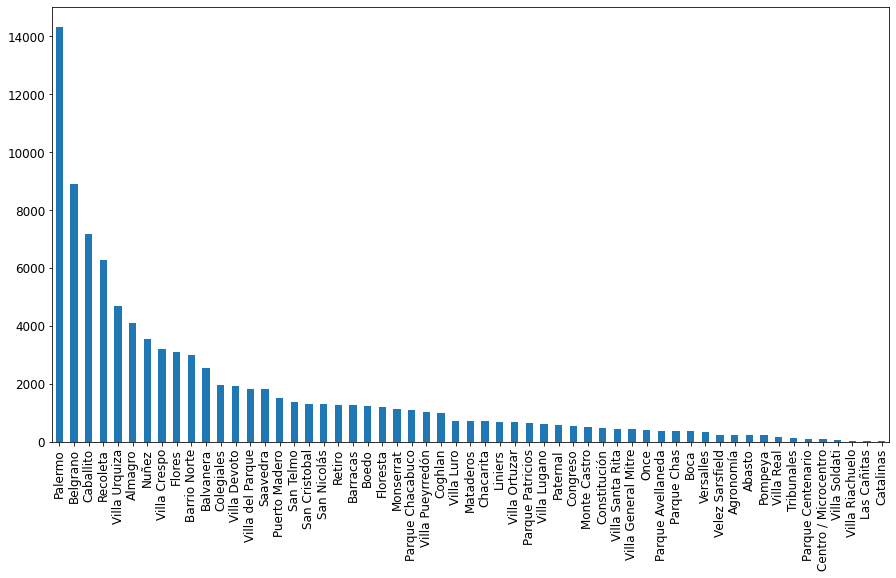

In [292]:
fig, ax = plt.subplots()
df['place_l3'].value_counts().plot(ax=ax, kind='bar', figsize=(15,8), fontsize=12)

In [293]:
print(f"place_l4 tiene {df.nunique()['place_l4']} valores diferentes")

place_l4 tiene 4 valores diferentes


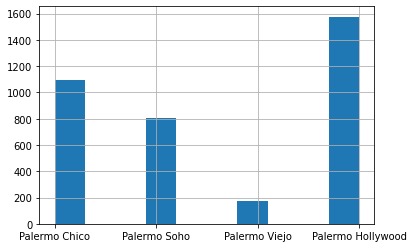

In [294]:
df['place_l4'].hist()

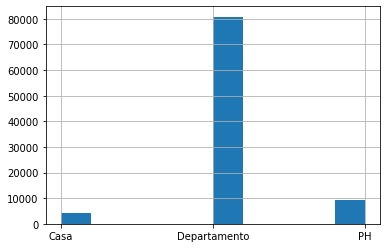

In [295]:
df['property_type'].hist()

In [296]:
print(f"property_type tiene {df.nunique()['property_type']} valores diferentes")

property_type tiene 3 valores diferentes


### Determinación de Variables Irrelevantes

---

Finalmente, podremos decir que dejamos fuera de este análisis particular a las a las siguientes variables que detallamos a continuación:

- `operation`: Sólo hay un tipo de operación según lo solicitado en la consigna y es "Venta", con lo cual la consideramos irrelevante en el análisis.
- `property_currency`: Sólo hay un tipo de cambio según lo solicitado en la consigna y es "USD", con lo cual la consideramos irrelevante en el análisis.
- `place_l5`: De analizar previamente el dataset con el cual estamos trabajando, detectamos que la columna en cuestión se encuentra vacía, con lo cual la consideramos irrelevante en el análisis.
- `place_l6`: De analizar previamente el dataset con el cual estamos trabajando, detectamos que la columna en cuestión se encuentra vacía, con lo cual la consideramos irrelevante en el análisis.
- `property_title`: De conocer previamente la información que contiene el dataset, sabemos que la variable en cuestión almacena un único título por publicación, con lo cual la consideramos irrelevante en el análisis.

### Análisis Gráfico de las Distribuciones de las Variables

---



#### Densidad de la variable `latitud`

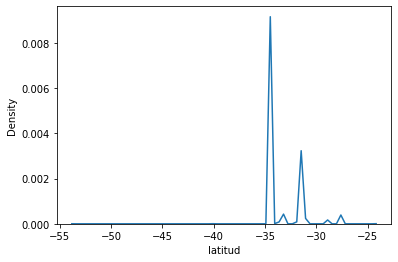

In [297]:
#grf = df['latitud'].plot.kde(title="Densidad variable Start date",xlabel="x",ylabel="y").xlim(-10, 10)
#sns.displot(df.latitud, hist=False, kde_kws={'clip': (-10.0, 10.0)})
# ver despues de machearlas con los property_types 
sns.kdeplot(data=df.latitud, gridsize=70)

#### Densidad de la variable `longitud`

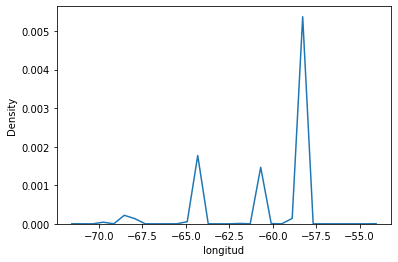

In [298]:
sns.kdeplot(data=df.longitud, gridsize=30)


#### Densidad de la variable `property_price`

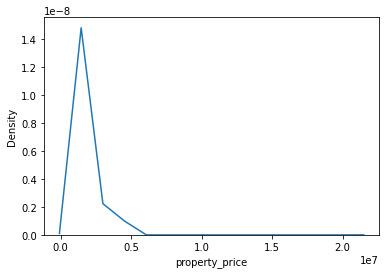

In [299]:
sns.kdeplot(data=df.property_price, gridsize=15)


#### Densidad de la variable `property_rooms`

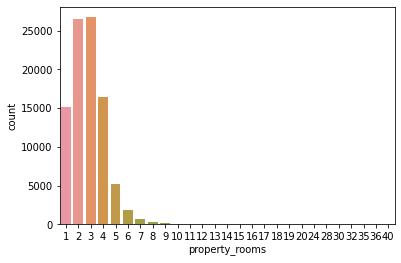

In [300]:
sns.countplot(x=df['property_rooms'].dropna().astype('int32'))

#### Densidad de la variable `property_surface_covered`

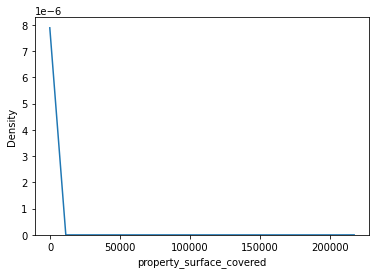

In [301]:
sns.kdeplot(data=df.property_surface_covered, gridsize=20)


### Análisis de las Correlaciones existentes entre las Variables

---

In [302]:
df.drop(["place_l5", "place_l6"], axis = 1, inplace = True)

In [303]:
#columns = df.columns.tolist()
#df_pariplot = df[columns].copy()
#graf_pairplot = sns.pairplot(data=df_pariplot, hue="property_type", palette=["r", "g", "b"])

## **1b. Datos Faltantes**

A continuación se realizara un análisis sobre los datos faltantes del dataframe.

Creamos una copia del dataset hasta el momento para comprar más adelante.

In [304]:
df_copy = df.copy()

### Análisis a Nivel Columna

---



Graficamos, para cada variable, el porcentaje (diferente de cero) de datos faltantes con respecto al total del dataset en escala logarítmica.

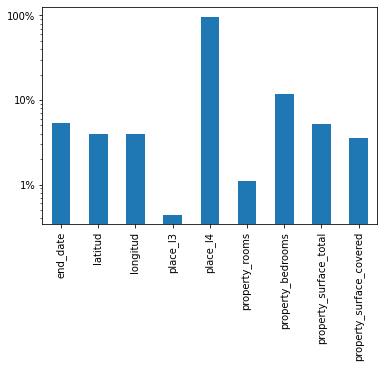

In [305]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.yaxis.set_major_formatter(PercentFormatter())
(df.isnull().sum() * 100 / len(df)).replace(0,np.nan).dropna(axis=0,how="all").plot(ax=ax, kind='bar')

### Análisis a Nivel Fila

---



Graficamos el porcentaje de filas con n datos faltantes con respecto al total del dataset.

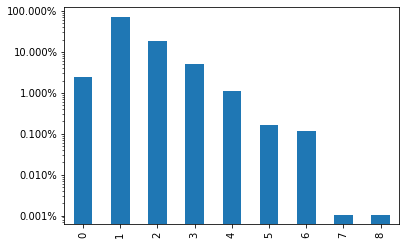

In [306]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.yaxis.set_major_formatter(PercentFormatter(decimals=3))
(df.isnull().sum(axis=1).value_counts().sort_index() * 100 / len(df)).plot(ax=ax, kind='bar')

### Reparación de Valores Faltantes

---



A continuación se detallan posibles estrategias para reparar los valores faltantes del dataset.

Reemplazamos las locaciones no definidas por el nivel superior

In [307]:
df.place_l3.fillna(df.place_l2, inplace=True)
df.place_l4.fillna(df.place_l3, inplace=True)

Reemplazamos la cantidad de dormitorios no definidos por la media calculada filtrando por cantidad total de habitaciones.


In [308]:
cant = df.loc[(df['property_bedrooms'].isna()) & (df['property_rooms'].notna())].property_rooms.value_counts().index.values

for i in cant:
    median = df.loc[(df['property_bedrooms'].notna()) & (df['property_rooms'] == i)].property_bedrooms.median()
    df.loc[(df['property_bedrooms'].isna()) & (df["property_rooms"] == i), "property_bedrooms"] = df.loc[(df['property_bedrooms'].isna()) & (df["property_rooms"] == i), "property_bedrooms"].fillna(median)


Luego reemplazamos la cantidad total de habitaciones no definidas por la media calculada filtrando por cantidad de dormitorios.

Esto redujo el porcentaje de valores no definidos para los dormitorios y habitaciones a menos de 1%, desde 10% y 1,5% respectivamente.

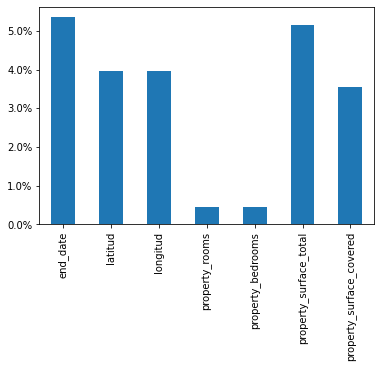

In [309]:
cant = df.loc[(df['property_rooms'].isna()) & (df['property_bedrooms'].notna())].property_bedrooms.value_counts().index.values

for i in cant:
    median = df.loc[(df['property_rooms'].notna()) & (df['property_bedrooms'] == i)].property_rooms.median()
    df.loc[(df['property_rooms'].isna()) & (df["property_bedrooms"] == i), "property_rooms"] = df.loc[(df['property_rooms'].isna()) & (df["property_bedrooms"] == i), "property_rooms"].fillna(median)
    
fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(PercentFormatter())
(df.isnull().sum() * 100 / len(df)).replace(0,np.nan).dropna(axis=0,how="all").plot(ax=ax, kind='bar')


Cuando se tiene la superficie total pero no la cubierta o viceversa, reemplazamos los valores faltantes con su contraparte

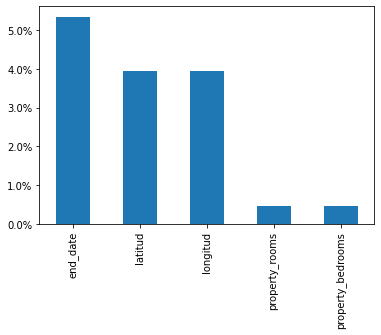

In [310]:
df.property_surface_total.fillna(df.property_surface_covered, inplace=True)
df.property_surface_covered.fillna(df.property_surface_total, inplace=True)

fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(PercentFormatter())
(df.isnull().sum() * 100 / len(df)).replace(0,np.nan).dropna(axis=0,how="all").plot(ax=ax, kind='bar')

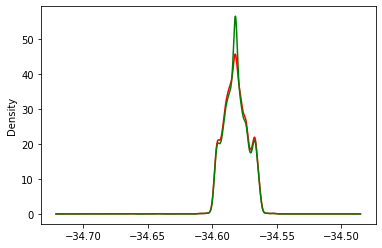

In [311]:
df.loc[df["place_l4"] == "Palermo"].latitud.plot.density(color = "red")
for barrio in df["place_l4"].unique() :
    lat_median = df.loc[(df["place_l4"] == barrio) & (df['latitud'].notna()) ].latitud.median()
    df.loc[(df["place_l4"] == barrio) & (df['latitud'].isna()), "latitud"] = df.loc[(df["place_l4"] == barrio) & (df['latitud'].isna()), "latitud"].fillna(lat_median)

df.loc[df["place_l4"] == "Palermo"].latitud.plot.density(color = "green")

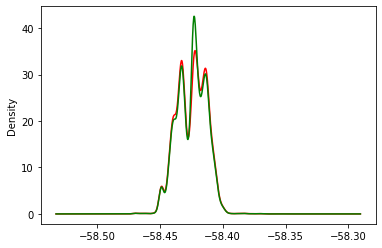

In [312]:
df.loc[df["place_l4"] == "Palermo"].longitud.plot.density(color = "red")
for barrio in df["place_l4"].unique() :
    long_median = df.loc[(df["place_l4"] == barrio) & (df['longitud'].notna())].longitud.median()
    df.loc[(df["place_l4"] == barrio) & (df['longitud'].isna()), "longitud"] = df.loc[(df["place_l4"] == barrio) & (df['longitud'].isna()), "longitud"].fillna(long_median)
    
df.loc[df["place_l4"] == "Palermo"].longitud.plot.density(color = "green")

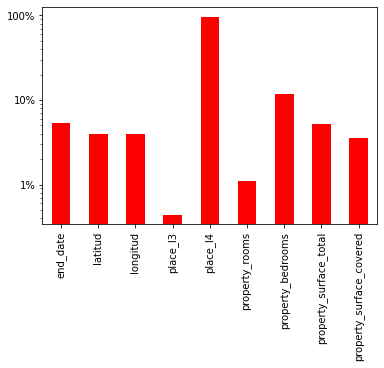

In [313]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.yaxis.set_major_formatter(PercentFormatter())
(df_copy.isnull().sum() * 100 / len(df_copy)).replace(0,np.nan).dropna(axis=0,how="all").plot(ax=ax, kind='bar', color="red", zorder=0)

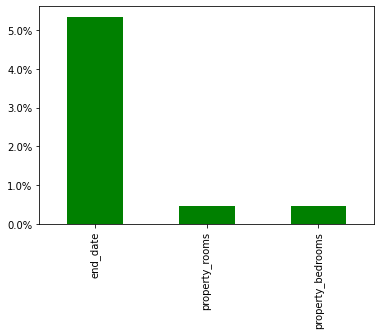

In [314]:
fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(PercentFormatter())
(df.isnull().sum() * 100 / len(df)).replace(0,np.nan).dropna(axis=0,how="all").plot(ax=ax, kind='bar', color="green", zorder=1)

## FALTA ARREGLAR LATITUD Y LONGITUD.

## **1c. Valores atípicos**

A continuación se realizara un análisis sobre los valores atípicos presentes en el dataframe. En la totalidad del dataset logramos detectar outliers tanto univariados (presentes en una unica variable) como multivariados (se encuentran en un espacio n-dimensional).

### Outliers univariados

---

Para el análisis de outliers de tipo univariados estaremos utilizando tanto el método de Box Plot como los métodos de Z-Score y Z-Score Modificado.

Mientras que el primero nos brindará información respecto de los topes superiores e inferiores de los cuartiles Q3 y Q1 respectivamente, los gráficos de Z-Score y Z-Score modificado nos permitirán visualizar de forma eficiente cómo se distribuye la masa de observaciones respecto de la media, y -por tanto- poder determinar de forma más precisa cuáles son los valores atípicos.

Por último, podremos destacar cuáles son las características de los valores en cuestión pudiendo clasificar los mismos en: global, contextual y colectivo.

#### Property rooms

##### Box plot

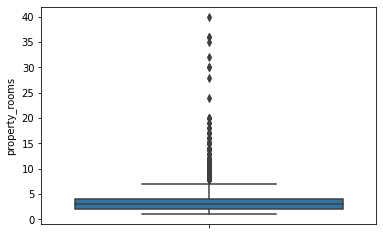

In [315]:
sns.boxplot(y=df.property_rooms)
plt.show()

In [316]:
# Cuartiles
Q1_property_rooms=df.describe().get("property_rooms").get("25%")
Q3_property_rooms=df.describe().get("property_rooms").get("75%")

print("El valor de Q1 es:", Q1_property_rooms)
print("El valor de Q3 es:", Q3_property_rooms)

# Rango intercuartil
IQR_property_rooms=Q3_property_rooms-Q1_property_rooms

# Limites Outliers
out_inf=Q1_property_rooms-1.5*IQR_property_rooms
out_sup=Q3_property_rooms+1.5*IQR_property_rooms
print("El limite inferior del Q1 es:", out_inf)
print("El limite superior del Q3 es:", out_sup)

El valor de Q1 es: 2.0
El valor de Q3 es: 4.0
El limite inferior del Q1 es: -1.0
El limite superior del Q3 es: 7.0


Confirmamos que tratamos con un outlier notando la relacion por ejemplo con la variable property rooms

In [317]:
outlier=df[df['property_rooms']>7]
outlier

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
58,tgaK6Ibor1zLY5bvNxsXfw==,2021-09-09,2021-09-26,2021-09-09,-34.633730,-58.424729,Capital Federal,Boedo,Boedo,Venta,Casa,10.0,10.0,394.0,244.0,500000.0,USD,VENTA CASA BOEDO LOCAL DEPARTAMENTOS HABITACI...
834,DW1aOtw9rrmcRJKrXV8lQQ==,2021-09-09,2022-03-09,2021-09-09,-34.586193,-58.396815,Capital Federal,Recoleta,Recoleta,Venta,Departamento,9.0,4.0,390.0,340.0,1200000.0,USD,“La Isla”-Gelly Obes-Copérnico-Espectacular pi...
1040,hg7z9YXumyiWLjMo6ed2Eg==,2021-09-09,2022-03-09,2021-09-09,-34.620750,-58.502759,Capital Federal,Villa Luro,Villa Luro,Venta,Casa,8.0,6.0,201.0,201.0,345000.0,USD,Casa Ideal Dos Familias - Monte Castro
1108,emutcNxb0N+nIgC7KPMFow==,2021-09-09,2022-03-09,2021-09-09,-34.620750,-58.502759,Capital Federal,Monte Castro,Monte Castro,Venta,Casa,8.0,6.0,201.0,201.0,345000.0,USD,Casa Ideal Dos Familias - Monte Castro
1349,fwH71WfOi+vE4kdGMHfWNQ==,2021-09-09,2022-03-09,2021-09-09,-34.620750,-58.502759,Capital Federal,Velez Sarsfield,Velez Sarsfield,Venta,Casa,8.0,6.0,201.0,201.0,345000.0,USD,Casa Ideal Dos Familias - Monte Castro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459706,rhZ7e0ygquCQbMZX+WCIcA==,2021-01-05,2021-02-03,2021-01-05,-34.592037,-58.396064,Capital Federal,Recoleta,Recoleta,Venta,Departamento,8.0,5.0,256.0,256.0,800000.0,USD,Excelente departamento con cochera en venta en...
459724,ZHK1Il6hnxI3iMhjvmD5+g==,2021-01-05,2021-10-16,2021-01-05,-34.587991,-58.389017,Capital Federal,Recoleta,Recoleta,Venta,Departamento,8.0,3.0,285.0,272.0,1250000.0,USD,Departamento de excelente categoria en venta e...
459755,oFcI5JAbOEsVvsk6PhM6fg==,2021-01-05,2022-06-12,2021-01-05,-34.590653,-58.384325,Capital Federal,Recoleta,Recoleta,Venta,Departamento,8.0,5.0,431.0,415.0,2800000.0,USD,Departamento de excelente calidad con 5 dormit...
459764,oX3aPs/sStr80cOS+VyxVw==,2021-01-05,NaT,2021-01-05,-34.586441,-58.387889,Capital Federal,Recoleta,Recoleta,Venta,Departamento,8.0,4.0,383.0,383.0,1700000.0,USD,Departamento frances con 2 cocheras en venta e...


In [318]:
outlier=df[df['property_rooms']<1]
outlier

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title


##### Z-Score

In [319]:
media_rooms=np.mean(df.property_rooms)
std_rooms=np.std(df.property_rooms)
df['z_rooms']=(df.property_rooms - media_rooms)/std_rooms

In [320]:
df[df['z_rooms']>3]

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title,z_rooms
58,tgaK6Ibor1zLY5bvNxsXfw==,2021-09-09,2021-09-26,2021-09-09,-34.633730,-58.424729,Capital Federal,Boedo,Boedo,Venta,Casa,10.0,10.0,394.0,244.0,500000.0,USD,VENTA CASA BOEDO LOCAL DEPARTAMENTOS HABITACI...,4.992871
834,DW1aOtw9rrmcRJKrXV8lQQ==,2021-09-09,2022-03-09,2021-09-09,-34.586193,-58.396815,Capital Federal,Recoleta,Recoleta,Venta,Departamento,9.0,4.0,390.0,340.0,1200000.0,USD,“La Isla”-Gelly Obes-Copérnico-Espectacular pi...,4.296317
1040,hg7z9YXumyiWLjMo6ed2Eg==,2021-09-09,2022-03-09,2021-09-09,-34.620750,-58.502759,Capital Federal,Villa Luro,Villa Luro,Venta,Casa,8.0,6.0,201.0,201.0,345000.0,USD,Casa Ideal Dos Familias - Monte Castro,3.599764
1108,emutcNxb0N+nIgC7KPMFow==,2021-09-09,2022-03-09,2021-09-09,-34.620750,-58.502759,Capital Federal,Monte Castro,Monte Castro,Venta,Casa,8.0,6.0,201.0,201.0,345000.0,USD,Casa Ideal Dos Familias - Monte Castro,3.599764
1349,fwH71WfOi+vE4kdGMHfWNQ==,2021-09-09,2022-03-09,2021-09-09,-34.620750,-58.502759,Capital Federal,Velez Sarsfield,Velez Sarsfield,Venta,Casa,8.0,6.0,201.0,201.0,345000.0,USD,Casa Ideal Dos Familias - Monte Castro,3.599764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459706,rhZ7e0ygquCQbMZX+WCIcA==,2021-01-05,2021-02-03,2021-01-05,-34.592037,-58.396064,Capital Federal,Recoleta,Recoleta,Venta,Departamento,8.0,5.0,256.0,256.0,800000.0,USD,Excelente departamento con cochera en venta en...,3.599764
459724,ZHK1Il6hnxI3iMhjvmD5+g==,2021-01-05,2021-10-16,2021-01-05,-34.587991,-58.389017,Capital Federal,Recoleta,Recoleta,Venta,Departamento,8.0,3.0,285.0,272.0,1250000.0,USD,Departamento de excelente categoria en venta e...,3.599764
459755,oFcI5JAbOEsVvsk6PhM6fg==,2021-01-05,2022-06-12,2021-01-05,-34.590653,-58.384325,Capital Federal,Recoleta,Recoleta,Venta,Departamento,8.0,5.0,431.0,415.0,2800000.0,USD,Departamento de excelente calidad con 5 dormit...,3.599764
459764,oX3aPs/sStr80cOS+VyxVw==,2021-01-05,NaT,2021-01-05,-34.586441,-58.387889,Capital Federal,Recoleta,Recoleta,Venta,Departamento,8.0,4.0,383.0,383.0,1700000.0,USD,Departamento frances con 2 cocheras en venta e...,3.599764


In [321]:
df[df['z_rooms']<-3]

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title,z_rooms


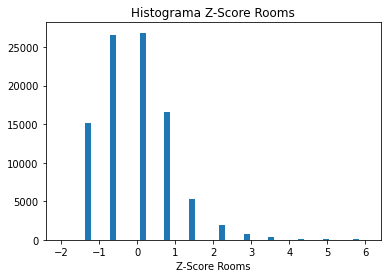

In [322]:
plt.hist(df.z_rooms, bins=50, range=(-2,6))
plt.title('Histograma Z-Score Rooms')
plt.xlabel('Z-Score Rooms')
plt.show()

##### Z-Score Modificado

In [323]:
mediana_room=np.nanmedian(df.property_rooms)

MAD=np.nanmedian(np.absolute(df.property_rooms-mediana_room))

df['zm_rooms']=(df.property_rooms - mediana_room)*0.6745/MAD

In [324]:
df['zm_rooms']

25        0.6745
42        0.0000
43        0.6745
49        0.6745
51        0.6745
           ...  
460072    0.6745
460073    0.0000
460074   -1.3490
460075   -1.3490
460090   -0.6745
Name: zm_rooms, Length: 94249, dtype: float64

In [325]:
df[(df['zm_rooms']>3.5)]

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title,z_rooms,zm_rooms
58,tgaK6Ibor1zLY5bvNxsXfw==,2021-09-09,2021-09-26,2021-09-09,-34.633730,-58.424729,Capital Federal,Boedo,Boedo,Venta,Casa,10.0,10.0,394.0,244.0,500000.0,USD,VENTA CASA BOEDO LOCAL DEPARTAMENTOS HABITACI...,4.992871,4.7215
834,DW1aOtw9rrmcRJKrXV8lQQ==,2021-09-09,2022-03-09,2021-09-09,-34.586193,-58.396815,Capital Federal,Recoleta,Recoleta,Venta,Departamento,9.0,4.0,390.0,340.0,1200000.0,USD,“La Isla”-Gelly Obes-Copérnico-Espectacular pi...,4.296317,4.0470
1769,g1hq2MUtnOPGU2VYSr2BWw==,2021-12-17,2022-01-27,2021-12-17,-34.623581,-58.484051,Capital Federal,Floresta,Floresta,Venta,Casa,10.0,6.0,240.0,240.0,320000.0,USD,Casa - Floresta,4.992871,4.7215
3071,r6wObBTHokmjYtHqvcAlyQ==,2021-02-20,2021-03-01,2021-02-20,-34.623590,-58.401566,Capital Federal,San Cristobal,San Cristobal,Venta,PH,15.0,15.0,355.0,215.0,220000.0,USD,PH 15 AMBIENTES HOTEL A RECICLAR San Cristóbal,8.475638,8.0940
6279,Ouq4jrslx03LUpqpoVwuTg==,2021-10-29,2022-01-27,2021-10-29,-34.593211,-58.390512,Capital Federal,Recoleta,Recoleta,Venta,Departamento,10.0,5.0,600.0,600.0,2000000.0,USD,PISO VIVIENDA APTO PROF EN RECOLETA LAS HERAS...,4.992871,4.7215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451439,xAhwsSTSgi3S3LwevVCiLA==,2021-12-16,2021-12-21,2021-12-16,-34.609154,-58.383631,Capital Federal,Congreso,Congreso,Venta,Departamento,10.0,9.0,240.0,227.0,370000.0,USD,Venta 10 amb - Congreso - Edificio Historico A...,4.992871,4.7215
453847,NTZQ7bMIl4KrSNE/Yna15A==,2021-12-16,2022-02-09,2021-12-16,-34.635489,-58.502057,Capital Federal,Villa Luro,Villa Luro,Venta,Casa,10.0,4.0,235.0,200.0,224000.0,USD,¡Venta Única! Casa en Villa Luro Patio y Terraza,4.992871,4.7215
457782,zThHFYUg/ZODnN9ekjwgFg==,2021-05-08,2021-06-05,2021-05-08,-34.581524,-58.403588,Capital Federal,Palermo,Palermo,Venta,Departamento,10.0,6.0,520.0,500.0,3300000.0,USD,Venta Departamento Palermo,4.992871,4.7215
458873,JklH0r8XBsFn3380WryLIw==,2021-01-05,NaT,2021-01-05,-34.625353,-58.372014,Capital Federal,San Telmo,San Telmo,Venta,Casa,12.0,12.0,820.0,820.0,550000.0,USD,Casa de 820 m2 en San Telmo,6.385977,6.0705


In [326]:
df[(df['zm_rooms']<-3.5)]

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title,z_rooms,zm_rooms


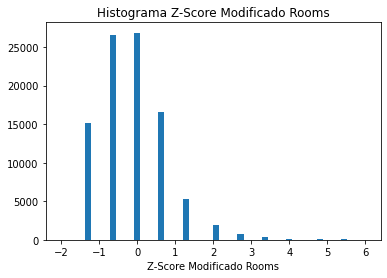

In [327]:
plt.hist(df.zm_rooms, bins=50, range=(-2,6))
plt.title('Histograma Z-Score Modificado Rooms')
plt.xlabel('Z-Score Modificado Rooms')
plt.show()

##### Características

Del análisis de los 3 gráficos previamente presentados, podemos concluir que, puesto que existe una gran masa conjunta de observaciones que superan el límite superior del tercer cuartil, podríamos decir que los outliers en cuestión son del tipo colectivo.

#### Property bedrooms

Al igual que los ambientes, podemos notar tambien aca la presencia de algunos valores lejanos a los extremos de los cuartiles que usamos de referencia. En particular tenemos uno notoriamente distanciado cercano al numero 70.

Repetimos los metodos anteriores.

 ##### Box plot


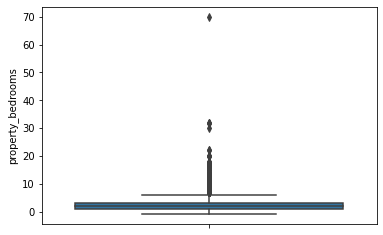

In [328]:
sns.boxplot(y=df.property_bedrooms)
plt.show()

In [329]:
# Cuartiles
Q1_property_bedrooms=df.describe().get("property_bedrooms").get("25%")
Q3_property_bedrooms=df.describe().get("property_bedrooms").get("75%")

print("El valor de Q1 es:", Q1_property_bedrooms)
print("El valor de Q3 es:", Q3_property_bedrooms)

# Rango intercuartil
IQR_property_bedrooms=Q3_property_bedrooms-Q1_property_bedrooms

# Limites Outliers
out_inf=Q1_property_bedrooms-1.5*IQR_property_bedrooms
out_sup=Q3_property_bedrooms+1.5*IQR_property_bedrooms
print("El limite inferior del Q1 es:", out_inf)
print("El limite superior del Q3 es:", out_sup)

El valor de Q1 es: 1.0
El valor de Q3 es: 3.0
El limite inferior del Q1 es: -2.0
El limite superior del Q3 es: 6.0


Confirmamos que tratamos con un outlier notando la relacion por ejemplo con la variable property rooms

In [330]:
outlier=df[df['property_bedrooms']>6]
outlier

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title,z_rooms,zm_rooms
58,tgaK6Ibor1zLY5bvNxsXfw==,2021-09-09,2021-09-26,2021-09-09,-34.633730,-58.424729,Capital Federal,Boedo,Boedo,Venta,Casa,10.0,10.0,394.0,244.0,500000.0,USD,VENTA CASA BOEDO LOCAL DEPARTAMENTOS HABITACI...,4.992871,4.7215
1800,xOxObQG9UHaTxLPYGOtK4w==,2021-12-17,2022-02-09,2021-12-17,-34.616128,-58.394715,Capital Federal,Balvanera,Balvanera,Venta,Casa,8.0,7.0,164.0,143.0,215000.0,USD,Casa 8 Ambientes ubicada en Balvanera,3.599764,3.3725
3071,r6wObBTHokmjYtHqvcAlyQ==,2021-02-20,2021-03-01,2021-02-20,-34.623590,-58.401566,Capital Federal,San Cristobal,San Cristobal,Venta,PH,15.0,15.0,355.0,215.0,220000.0,USD,PH 15 AMBIENTES HOTEL A RECICLAR San Cristóbal,8.475638,8.0940
6355,PZJRORTIAvMTvI3A+FLDUQ==,2021-10-29,2021-11-03,2021-10-29,-34.577180,-58.451264,Capital Federal,Colegiales,Colegiales,Venta,Departamento,6.0,8.0,424.0,324.0,660000.0,USD,DEPARTAMENTOS CON 2 UNIDADES COMPLEMENTARIAS E...,2.206657,2.0235
6869,vtFpL0vRYrdtMyLuHCrhkQ==,2021-02-09,NaT,2021-02-09,-34.631952,-58.373878,Capital Federal,Barracas,Barracas,Venta,Casa,8.0,7.0,350.0,350.0,550000.0,USD,EXCELENTE CASA EN TERRENO PROPIO,3.599764,3.3725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451439,xAhwsSTSgi3S3LwevVCiLA==,2021-12-16,2021-12-21,2021-12-16,-34.609154,-58.383631,Capital Federal,Congreso,Congreso,Venta,Departamento,10.0,9.0,240.0,227.0,370000.0,USD,Venta 10 amb - Congreso - Edificio Historico A...,4.992871,4.7215
457063,D2v8pvBdj56lpVuQPiSbQA==,2021-05-08,2021-05-20,2021-05-08,-34.572554,-58.469842,Capital Federal,Belgrano,Belgrano,Venta,Casa,8.0,7.0,400.0,400.0,920000.0,USD,Casa - Belgrano R - Esquina,3.599764,3.3725
457064,rWpwKlxzNHvQYcrs+sBijQ==,2021-05-08,2021-05-20,2021-05-08,-34.572554,-58.469842,Capital Federal,Belgrano,Belgrano,Venta,Casa,8.0,7.0,400.0,400.0,920000.0,USD,Casa - Belgrano R - Lote propio - Esquina - Oc...,3.599764,3.3725
458873,JklH0r8XBsFn3380WryLIw==,2021-01-05,NaT,2021-01-05,-34.625353,-58.372014,Capital Federal,San Telmo,San Telmo,Venta,Casa,12.0,12.0,820.0,820.0,550000.0,USD,Casa de 820 m2 en San Telmo,6.385977,6.0705


##### Z-Score

In [331]:
media_bedrooms=np.mean(df.property_bedrooms)
std_bedrooms=np.std(df.property_bedrooms)
df['z_bedrooms']=(df.property_bedrooms - media_bedrooms)/std_bedrooms

In [332]:
df[df['z_bedrooms']>3]

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,operation,...,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title,z_rooms,zm_rooms,z_bedrooms
58,tgaK6Ibor1zLY5bvNxsXfw==,2021-09-09,2021-09-26,2021-09-09,-34.633730,-58.424729,Capital Federal,Boedo,Boedo,Venta,...,10.0,10.0,394.0,244.0,500000.0,USD,VENTA CASA BOEDO LOCAL DEPARTAMENTOS HABITACI...,4.992871,4.7215,7.237343
1040,hg7z9YXumyiWLjMo6ed2Eg==,2021-09-09,2022-03-09,2021-09-09,-34.620750,-58.502759,Capital Federal,Villa Luro,Villa Luro,Venta,...,8.0,6.0,201.0,201.0,345000.0,USD,Casa Ideal Dos Familias - Monte Castro,3.599764,3.3725,3.657724
1108,emutcNxb0N+nIgC7KPMFow==,2021-09-09,2022-03-09,2021-09-09,-34.620750,-58.502759,Capital Federal,Monte Castro,Monte Castro,Venta,...,8.0,6.0,201.0,201.0,345000.0,USD,Casa Ideal Dos Familias - Monte Castro,3.599764,3.3725,3.657724
1349,fwH71WfOi+vE4kdGMHfWNQ==,2021-09-09,2022-03-09,2021-09-09,-34.620750,-58.502759,Capital Federal,Velez Sarsfield,Velez Sarsfield,Venta,...,8.0,6.0,201.0,201.0,345000.0,USD,Casa Ideal Dos Familias - Monte Castro,3.599764,3.3725,3.657724
1363,rfG2Nb7079oZOP8wAKuwXA==,2021-09-09,2022-03-09,2021-09-09,-34.620750,-58.502759,Capital Federal,Villa Santa Rita,Villa Santa Rita,Venta,...,8.0,6.0,201.0,201.0,345000.0,USD,Casa Ideal Dos Familias - Monte Castro,3.599764,3.3725,3.657724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457366,addYhPIIGDmKeww0LFYSTg==,2021-05-08,2021-06-05,2021-05-08,-34.631404,-58.403266,Capital Federal,Parque Patricios,Parque Patricios,Venta,...,7.0,6.0,280.0,230.0,426000.0,USD,Casa - Parque Patricios,2.903210,2.6980,3.657724
457782,zThHFYUg/ZODnN9ekjwgFg==,2021-05-08,2021-06-05,2021-05-08,-34.581524,-58.403588,Capital Federal,Palermo,Palermo,Venta,...,10.0,6.0,520.0,500.0,3300000.0,USD,Venta Departamento Palermo,4.992871,4.7215,3.657724
458670,naEatqtTCG8ALXICib4ZxQ==,2021-01-05,2022-08-12,2021-01-05,-34.577390,-58.475421,Capital Federal,Villa Urquiza,Villa Urquiza,Venta,...,5.0,6.0,125.0,100.0,265000.0,USD,Alvarez Thomas 2400 Exc PH SIN EXPENSAS- 5 am...,1.510104,1.3490,3.657724
458873,JklH0r8XBsFn3380WryLIw==,2021-01-05,NaT,2021-01-05,-34.625353,-58.372014,Capital Federal,San Telmo,San Telmo,Venta,...,12.0,12.0,820.0,820.0,550000.0,USD,Casa de 820 m2 en San Telmo,6.385977,6.0705,9.027152


In [333]:
df[df['z_bedrooms']<-3]

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,operation,...,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title,z_rooms,zm_rooms,z_bedrooms


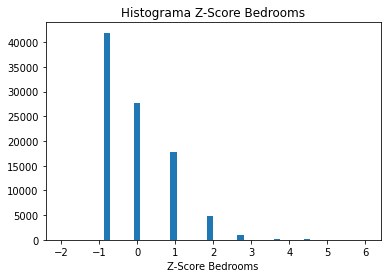

In [334]:
plt.hist(df.z_bedrooms, bins=50, range=(-2,6))
plt.title('Histograma Z-Score Bedrooms')
plt.xlabel('Z-Score Bedrooms')
plt.show()

##### Z-Score Modificado

In [335]:
mediana_bedroom=np.nanmedian(df.property_bedrooms)
MAD=np.nanmedian(np.absolute(df.property_bedrooms-mediana_bedroom))

df['zm_bedrooms']=(df.property_bedrooms - mediana_bedroom)*0.6745/MAD

In [336]:
df[(df['zm_bedrooms']>3.5)]

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,operation,...,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms
58,tgaK6Ibor1zLY5bvNxsXfw==,2021-09-09,2021-09-26,2021-09-09,-34.633730,-58.424729,Capital Federal,Boedo,Boedo,Venta,...,10.0,394.0,244.0,500000.0,USD,VENTA CASA BOEDO LOCAL DEPARTAMENTOS HABITACI...,4.992871,4.7215,7.237343,5.3960
3071,r6wObBTHokmjYtHqvcAlyQ==,2021-02-20,2021-03-01,2021-02-20,-34.623590,-58.401566,Capital Federal,San Cristobal,San Cristobal,Venta,...,15.0,355.0,215.0,220000.0,USD,PH 15 AMBIENTES HOTEL A RECICLAR San Cristóbal,8.475638,8.0940,11.711866,8.7685
6355,PZJRORTIAvMTvI3A+FLDUQ==,2021-10-29,2021-11-03,2021-10-29,-34.577180,-58.451264,Capital Federal,Colegiales,Colegiales,Venta,...,8.0,424.0,324.0,660000.0,USD,DEPARTAMENTOS CON 2 UNIDADES COMPLEMENTARIAS E...,2.206657,2.0235,5.447533,4.0470
6920,7zvivHSapxLYLTcr6PsxAQ==,2021-02-09,NaT,2021-02-09,-34.620995,-58.374707,Capital Federal,San Telmo,San Telmo,Venta,...,9.0,511.0,380.0,920000.0,USD,CASA VENTA SAN TELMO,4.992871,4.7215,6.342438,4.7215
6922,TE83wpYe7pIeb5E3T7UxuA==,2021-02-09,2021-02-10,2021-02-09,-34.623819,-58.371153,Capital Federal,San Telmo,San Telmo,Venta,...,10.0,750.0,750.0,1500000.0,USD,Casa en venta en San Telmo,5.689424,5.3960,7.237343,5.3960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438314,niN7qH7fPC5WZf1e/w5VgA==,2021-04-23,2021-06-05,2021-04-23,-34.624766,-58.418918,Capital Federal,Boedo,Boedo,Venta,...,9.0,1019.0,1019.0,820000.0,USD,Edificio ubicado en el Barrio de Boedo en Vent...,11.958405,11.4665,6.342438,4.7215
449070,rBF+6yKQXe/+8WAhVElKjg==,2021-12-16,2022-03-25,2021-12-16,-34.629306,-58.465354,Capital Federal,Flores,Flores,Venta,...,8.0,275.0,275.0,219000.0,USD,Piso 275 m2 Rivadavia y Varela,3.599764,3.3725,5.447533,4.0470
451439,xAhwsSTSgi3S3LwevVCiLA==,2021-12-16,2021-12-21,2021-12-16,-34.609154,-58.383631,Capital Federal,Congreso,Congreso,Venta,...,9.0,240.0,227.0,370000.0,USD,Venta 10 amb - Congreso - Edificio Historico A...,4.992871,4.7215,6.342438,4.7215
458873,JklH0r8XBsFn3380WryLIw==,2021-01-05,NaT,2021-01-05,-34.625353,-58.372014,Capital Federal,San Telmo,San Telmo,Venta,...,12.0,820.0,820.0,550000.0,USD,Casa de 820 m2 en San Telmo,6.385977,6.0705,9.027152,6.7450


In [337]:
df[(df['zm_bedrooms']<-3.5)]

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,operation,...,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms


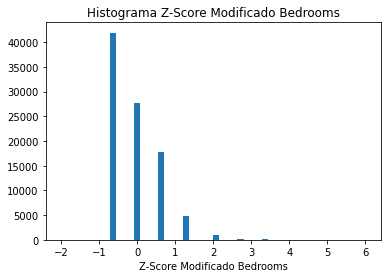

In [338]:
plt.hist(df.zm_bedrooms, bins=50, range=(-2,6))
plt.title('Histograma Z-Score Modificado Bedrooms')
plt.xlabel('Z-Score Modificado Bedrooms')
plt.show()

##### Características

Del análisis de los 3 gráficos previamente presentados, podemos concluir que, puesto que existe una gran masa conjunta de observaciones atípicas y una singular -también atípica- lejana a la masa en cuestión- podríamos decir que los outliers son del tipo colectivo (para la masa de observaciones cerca del máximo para el tercer cuartil) y global (para la singular por encima del resto de las observaciones).

#### Property price

##### Box plot

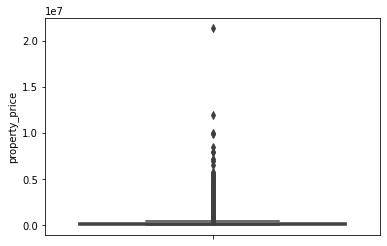

In [339]:
sns.boxplot(y=df.property_price)
plt.show()

In [340]:
# Cuartiles
Q1_property_price=df.describe().get("property_price").get("25%")
Q3_property_price=df.describe().get("property_price").get("75%")

print("El valor de Q1 es:", Q1_property_price)
print("El valor de Q3 es:", Q3_property_price)

# Rango intercuartil
IQR_property_price=Q3_property_price-Q1_property_price

# Limites Outliers
out_inf=Q1_property_price-1.5*IQR_property_price
out_sup=Q3_property_price+1.5*IQR_property_price
print("El limite inferior del Q1 es:", out_inf)
print("El limite superior del Q3 es:", out_sup)

El valor de Q1 es: 95000.0
El valor de Q3 es: 237000.0
El limite inferior del Q1 es: -118000.0
El limite superior del Q3 es: 450000.0


Confirmamos que tratamos con un outlier

In [341]:
outlier=df[df['property_price']>450000]
outlier

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,operation,...,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms
58,tgaK6Ibor1zLY5bvNxsXfw==,2021-09-09,2021-09-26,2021-09-09,-34.633730,-58.424729,Capital Federal,Boedo,Boedo,Venta,...,10.0,394.0,244.0,500000.0,USD,VENTA CASA BOEDO LOCAL DEPARTAMENTOS HABITACI...,4.992871,4.7215,7.237343,5.3960
410,S8iZ1eflTJtt4bejzBVktw==,2021-09-09,2021-09-10,2021-09-09,-34.576741,-58.404830,Capital Federal,Palermo,Palermo Chico,Venta,...,4.0,400.0,400.0,2700000.0,USD,Departamento - Palermo Chico,1.510104,1.3490,1.867914,1.3490
411,FblpEe26U1lQkU5vRzAtmg==,2021-09-09,2021-09-09,2021-09-09,-34.576741,-58.404830,Capital Federal,Palermo,Palermo Chico,Venta,...,4.0,400.0,400.0,2700000.0,USD,Departamento - Palermo Chico,1.510104,1.3490,1.867914,1.3490
438,taPk4LSPMT26ftJm7/Bh6Q==,2021-09-09,2022-03-06,2021-09-09,-34.575053,-58.407958,Capital Federal,Palermo,Palermo Chico,Venta,...,3.0,282.0,256.0,2250000.0,USD,Torre Vignoli 282 metros . 3 suites . 2 cocheras,0.813550,0.6745,0.973010,0.6745
448,0Ui0Bm9reiNrJFdUfgXwiA==,2021-09-09,2022-01-27,2021-09-09,-34.577855,-58.408796,Capital Federal,Palermo,Palermo Chico,Venta,...,4.0,304.0,294.0,1200000.0,USD,Departamento de 5 ambientes con dependencia -...,1.510104,1.3490,1.867914,1.3490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459868,flZJmrO8SSTHv+d+AoanUw==,2021-01-05,2021-04-20,2021-01-05,-34.626835,-58.372299,Capital Federal,San Telmo,San Telmo,Venta,...,2.0,174.0,155.0,530000.0,USD,La esquina mas linda de San Telmo en venta,1.510104,1.3490,0.078105,0.0000
459986,Pxz0dKZgWiL7odLclgK/vA==,2021-01-05,NaT,2021-01-05,-34.613000,-58.362117,Capital Federal,Puerto Madero,Puerto Madero,Venta,...,2.0,176.0,163.0,790000.0,USD,Departamento en venta en Puerto Madero,0.116997,0.0000,0.078105,0.0000
459997,q3Im3Bm7Mi9ufVUH5rjWxw==,2021-01-05,2021-06-05,2021-01-05,-34.618084,-58.359912,Capital Federal,Puerto Madero,Puerto Madero,Venta,...,2.0,315.0,180.0,2200000.0,USD,Venta Departamento Pent House 4 Ambientes Pil...,0.813550,0.6745,0.078105,0.0000
460002,w+3qsITCAFukJ0S15B8znQ==,2021-01-05,2021-07-07,2021-01-05,-34.618595,-58.361978,Capital Federal,Puerto Madero,Puerto Madero,Venta,...,1.0,68.0,56.0,520000.0,USD,Excelente Suite en Hotel SLS Puerto Madero | 2...,-0.579557,-0.6745,-0.816800,-0.6745


##### Z-Score

In [342]:
media_price=np.mean(df.property_price)
std_price=np.std(df.property_price)
df['z_price']=(df.property_price - media_price)/std_price

In [343]:
df[df['z_price']>3]

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,operation,...,property_surface_total,property_surface_covered,property_price,property_currency,property_title,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms,z_price
410,S8iZ1eflTJtt4bejzBVktw==,2021-09-09,2021-09-10,2021-09-09,-34.576741,-58.404830,Capital Federal,Palermo,Palermo Chico,Venta,...,400.0,400.0,2700000.0,USD,Departamento - Palermo Chico,1.510104,1.3490,1.867914,1.3490,7.764431
411,FblpEe26U1lQkU5vRzAtmg==,2021-09-09,2021-09-09,2021-09-09,-34.576741,-58.404830,Capital Federal,Palermo,Palermo Chico,Venta,...,400.0,400.0,2700000.0,USD,Departamento - Palermo Chico,1.510104,1.3490,1.867914,1.3490,7.764431
438,taPk4LSPMT26ftJm7/Bh6Q==,2021-09-09,2022-03-06,2021-09-09,-34.575053,-58.407958,Capital Federal,Palermo,Palermo Chico,Venta,...,282.0,256.0,2250000.0,USD,Torre Vignoli 282 metros . 3 suites . 2 cocheras,0.813550,0.6745,0.973010,0.6745,6.352010
448,0Ui0Bm9reiNrJFdUfgXwiA==,2021-09-09,2022-01-27,2021-09-09,-34.577855,-58.408796,Capital Federal,Palermo,Palermo Chico,Venta,...,304.0,294.0,1200000.0,USD,Departamento de 5 ambientes con dependencia -...,1.510104,1.3490,1.867914,1.3490,3.056360
629,1Q/fC60k0cGKYTu6hUqf1g==,2021-09-09,2021-09-11,2021-09-09,-34.566536,-58.448246,Capital Federal,Belgrano,Belgrano,Venta,...,214.0,196.0,1200000.0,USD,Departamento - Belgrano,0.813550,0.6745,0.973010,0.6745,3.056360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459724,ZHK1Il6hnxI3iMhjvmD5+g==,2021-01-05,2021-10-16,2021-01-05,-34.587991,-58.389017,Capital Federal,Recoleta,Recoleta,Venta,...,285.0,272.0,1250000.0,USD,Departamento de excelente categoria en venta e...,3.599764,3.3725,0.973010,0.6745,3.213296
459729,gMY0XZIwhoegKoroHdxyrw==,2021-01-05,2022-09-15,2021-01-05,-34.587588,-58.389527,Capital Federal,Recoleta,Recoleta,Venta,...,271.0,265.0,1250000.0,USD,Departamento - Recoleta,2.206657,2.0235,0.973010,0.6745,3.213296
459755,oFcI5JAbOEsVvsk6PhM6fg==,2021-01-05,2022-06-12,2021-01-05,-34.590653,-58.384325,Capital Federal,Recoleta,Recoleta,Venta,...,431.0,415.0,2800000.0,USD,Departamento de excelente calidad con 5 dormit...,3.599764,3.3725,2.762819,2.0235,8.078303
459764,oX3aPs/sStr80cOS+VyxVw==,2021-01-05,NaT,2021-01-05,-34.586441,-58.387889,Capital Federal,Recoleta,Recoleta,Venta,...,383.0,383.0,1700000.0,USD,Departamento frances con 2 cocheras en venta e...,3.599764,3.3725,1.867914,1.3490,4.625717


In [344]:
df[df['z_price']<-3]

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,operation,...,property_surface_total,property_surface_covered,property_price,property_currency,property_title,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms,z_price


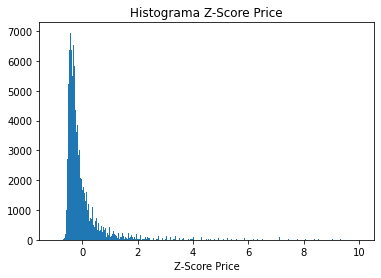

In [345]:
plt.hist(df.z_price, bins=300, range=(-1,10))
plt.title('Histograma Z-Score Price')
plt.xlabel('Z-Score Price')
plt.show()

##### Z-Score Modificado

In [346]:
mediana_price=np.nanmedian(df.property_price)
MAD=np.nanmedian(np.absolute(df.property_price-mediana_price))

df['zm_price']=(df.property_price - mediana_price)*0.6745/MAD

In [347]:
df[(df['zm_price']>3.5)]

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,operation,...,property_surface_covered,property_price,property_currency,property_title,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms,z_price,zm_price
58,tgaK6Ibor1zLY5bvNxsXfw==,2021-09-09,2021-09-26,2021-09-09,-34.633730,-58.424729,Capital Federal,Boedo,Boedo,Venta,...,244.0,500000.0,USD,VENTA CASA BOEDO LOCAL DEPARTAMENTOS HABITACI...,4.992871,4.7215,7.237343,5.3960,0.859260,4.141197
410,S8iZ1eflTJtt4bejzBVktw==,2021-09-09,2021-09-10,2021-09-09,-34.576741,-58.404830,Capital Federal,Palermo,Palermo Chico,Venta,...,400.0,2700000.0,USD,Departamento - Palermo Chico,1.510104,1.3490,1.867914,1.3490,7.764431,29.725680
411,FblpEe26U1lQkU5vRzAtmg==,2021-09-09,2021-09-09,2021-09-09,-34.576741,-58.404830,Capital Federal,Palermo,Palermo Chico,Venta,...,400.0,2700000.0,USD,Departamento - Palermo Chico,1.510104,1.3490,1.867914,1.3490,7.764431,29.725680
438,taPk4LSPMT26ftJm7/Bh6Q==,2021-09-09,2022-03-06,2021-09-09,-34.575053,-58.407958,Capital Federal,Palermo,Palermo Chico,Venta,...,256.0,2250000.0,USD,Torre Vignoli 282 metros . 3 suites . 2 cocheras,0.813550,0.6745,0.973010,0.6745,6.352010,24.492491
448,0Ui0Bm9reiNrJFdUfgXwiA==,2021-09-09,2022-01-27,2021-09-09,-34.577855,-58.408796,Capital Federal,Palermo,Palermo Chico,Venta,...,294.0,1200000.0,USD,Departamento de 5 ambientes con dependencia -...,1.510104,1.3490,1.867914,1.3490,3.056360,12.281715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459986,Pxz0dKZgWiL7odLclgK/vA==,2021-01-05,NaT,2021-01-05,-34.613000,-58.362117,Capital Federal,Puerto Madero,Puerto Madero,Venta,...,163.0,790000.0,USD,Departamento en venta en Puerto Madero,0.116997,0.0000,0.078105,0.0000,1.769487,7.513697
459997,q3Im3Bm7Mi9ufVUH5rjWxw==,2021-01-05,2021-06-05,2021-01-05,-34.618084,-58.359912,Capital Federal,Puerto Madero,Puerto Madero,Venta,...,180.0,2200000.0,USD,Venta Departamento Pent House 4 Ambientes Pil...,0.813550,0.6745,0.078105,0.0000,6.195074,23.911025
460002,w+3qsITCAFukJ0S15B8znQ==,2021-01-05,2021-07-07,2021-01-05,-34.618595,-58.361978,Capital Federal,Puerto Madero,Puerto Madero,Venta,...,56.0,520000.0,USD,Excelente Suite en Hotel SLS Puerto Madero | 2...,-0.579557,-0.6745,-0.816800,-0.6745,0.922034,4.373784
460005,U2WS7omU6g9aUPRuyLt+IA==,2021-01-05,2022-06-02,2021-01-05,-34.614730,-58.361755,Capital Federal,Puerto Madero,Puerto Madero,Venta,...,86.0,450000.0,USD,Departamento en venta en el Porteño Building,-0.579557,-0.6745,-0.816800,-0.6745,0.702324,3.559732


In [348]:
df[(df['zm_price']<-3.5)]

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,operation,...,property_surface_covered,property_price,property_currency,property_title,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms,z_price,zm_price


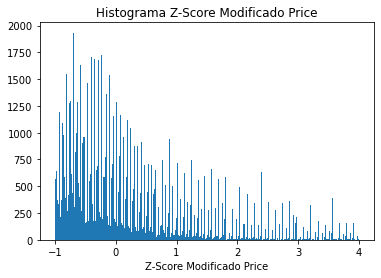

In [349]:
plt.hist(df.zm_price, bins=300, range=(-1,4))
plt.title('Histograma Z-Score Modificado Price')
plt.xlabel('Z-Score Modificado Price')
plt.show()

##### Características

Nuevamente, concluimos que al existir una gran masa conjunta de observaciones atípicas y una singular -también atípica- lejana a la masa en cuestión- podríamos decir que los outliers son del tipo colectivo (para la masa de observaciones cerca del máximo para el tercer cuartil) y global (para la observación singular por encima del resto de las observaciones).

#### Property surface covered

##### Box plot

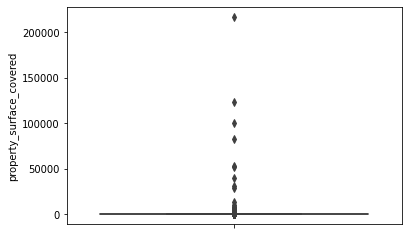

In [350]:
sns.boxplot(y=df.property_surface_covered)
plt.show()

In [351]:
# Cuartiles
Q1_property_surface_covered=df.describe().get("property_surface_covered").get("25%")
Q3_property_surface_covered=df.describe().get("property_surface_covered").get("75%")

print("El valor de Q1 es:", Q1_property_surface_covered)
print("El valor de Q3 es:", Q3_property_surface_covered)

# Rango intercuartil
IQR_property_surface_covered=Q3_property_surface_covered-Q1_property_surface_covered

# Limites Outliers
out_inf=Q1_property_surface_covered-1.5*IQR_property_surface_covered
out_sup=Q3_property_surface_covered+1.5*IQR_property_surface_covered
print("El limite inferior del Q1 es:", out_inf)
print("El limite superior del Q3 es:", out_sup)

El valor de Q1 es: 40.0
El valor de Q3 es: 89.0
El limite inferior del Q1 es: -33.5
El limite superior del Q3 es: 162.5


Confirmamos que tratamos con un outlier

In [352]:
outlier=df[df['property_surface_covered']>out_sup]
outlier

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,operation,...,property_surface_covered,property_price,property_currency,property_title,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms,z_price,zm_price
58,tgaK6Ibor1zLY5bvNxsXfw==,2021-09-09,2021-09-26,2021-09-09,-34.633730,-58.424729,Capital Federal,Boedo,Boedo,Venta,...,244.0,500000.0,USD,VENTA CASA BOEDO LOCAL DEPARTAMENTOS HABITACI...,4.992871,4.7215,7.237343,5.3960,0.859260,4.141197
410,S8iZ1eflTJtt4bejzBVktw==,2021-09-09,2021-09-10,2021-09-09,-34.576741,-58.404830,Capital Federal,Palermo,Palermo Chico,Venta,...,400.0,2700000.0,USD,Departamento - Palermo Chico,1.510104,1.3490,1.867914,1.3490,7.764431,29.725680
411,FblpEe26U1lQkU5vRzAtmg==,2021-09-09,2021-09-09,2021-09-09,-34.576741,-58.404830,Capital Federal,Palermo,Palermo Chico,Venta,...,400.0,2700000.0,USD,Departamento - Palermo Chico,1.510104,1.3490,1.867914,1.3490,7.764431,29.725680
438,taPk4LSPMT26ftJm7/Bh6Q==,2021-09-09,2022-03-06,2021-09-09,-34.575053,-58.407958,Capital Federal,Palermo,Palermo Chico,Venta,...,256.0,2250000.0,USD,Torre Vignoli 282 metros . 3 suites . 2 cocheras,0.813550,0.6745,0.973010,0.6745,6.352010,24.492491
448,0Ui0Bm9reiNrJFdUfgXwiA==,2021-09-09,2022-01-27,2021-09-09,-34.577855,-58.408796,Capital Federal,Palermo,Palermo Chico,Venta,...,294.0,1200000.0,USD,Departamento de 5 ambientes con dependencia -...,1.510104,1.3490,1.867914,1.3490,3.056360,12.281715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459842,Y4PuRUaAW17tsLGwFTukhA==,2021-01-05,2021-01-09,2021-01-05,-34.628397,-58.437706,Capital Federal,Caballito,Caballito,Venta,...,6472.0,203550.0,USD,3 Ambientes Venta de Pozo Caballito Full Ameni...,0.116997,0.0000,0.078105,0.0000,-0.071212,0.693688
459847,zMligt7YdiayCjrfqlmbfg==,2021-01-05,2021-01-09,2021-01-05,-34.628247,-58.437696,Capital Federal,Caballito,Caballito,Venta,...,8568.0,324558.0,USD,4 Ambientes Venta de Pozo Caballito Full Ameni...,0.813550,0.6745,0.973010,0.6745,0.308598,2.100928
459849,+9w0GBZbuObF0Nw6AAtu2Q==,2021-01-05,2021-01-09,2021-01-05,-34.628282,-58.437803,Capital Federal,Caballito,Caballito,Venta,...,5970.0,167894.0,USD,3 Ambientes Venta de Pozo Caballito Full Ameni...,0.116997,0.0000,0.078105,0.0000,-0.183126,0.279034
459986,Pxz0dKZgWiL7odLclgK/vA==,2021-01-05,NaT,2021-01-05,-34.613000,-58.362117,Capital Federal,Puerto Madero,Puerto Madero,Venta,...,163.0,790000.0,USD,Departamento en venta en Puerto Madero,0.116997,0.0000,0.078105,0.0000,1.769487,7.513697


##### Z-Score

In [353]:
media_surface_covered=np.mean(df.property_surface_covered)
std_surface_covered=np.std(df.property_surface_covered)
df['z_surface_covered']=(df.property_surface_covered - media_surface_covered)/std_surface_covered

In [354]:
df[df['z_surface_covered']>3]

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,operation,...,property_price,property_currency,property_title,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms,z_price,zm_price,z_surface_covered
1140,ddV7Ll5c1H+Rmqqovc+uFg==,2021-09-09,2022-01-27,2021-09-09,-34.605781,-58.376705,Capital Federal,San Nicolás,San Nicolás,Venta,...,9900000.0,USD,EDIFICIO A TERMINAR DE 900M2- EXCELENTE UBICAC...,NaN,NaN,NaN,NaN,30.363174,113.456715,10.695485
1932,eQ/SiyES/mXWsSyAzb3k3A==,2021-12-17,NaT,2021-12-17,-34.637026,-58.426283,Capital Federal,Parque Chacabuco,Parque Chacabuco,Venta,...,250000.0,USD,EXCEPCIONAL CASA DOS FAMILIAS - Parque Chacabuco,NaN,NaN,NaN,NaN,0.074581,1.233870,222.821967
30359,rpeGyTLDvloNDFf/CSF6Aw==,2021-10-15,2022-01-27,2021-10-15,-34.620995,-58.374707,Capital Federal,San Telmo,San Telmo,Venta,...,93500.0,USD,Dptos 2 amb a estrenar en San Telmo!!!,-0.579557,-0.6745,-0.816800,-0.6745,-0.416627,-0.586117,4.465232
72316,BPTyNzwU2D4btCduu8ls3A==,2021-05-29,2021-06-08,2021-05-29,-34.578917,-58.429373,Capital Federal,Palermo,Palermo,Venta,...,225000.0,USD,VENTA DEPARTAMENTO 2 AMBIENTES PALERMO C/AMENI...,-0.579557,-0.6745,-0.816800,-0.6745,-0.003886,0.943137,54.384295
72521,csbBJk04jQXgGZLXTj5WAg==,2021-05-29,2021-06-13,2021-05-29,-34.600113,-58.403649,Capital Federal,Balvanera,Balvanera,Venta,...,66000.0,USD,VENTA 2 AMBIENTES CON RENTA,-0.579557,-0.6745,-0.816800,-0.6745,-0.502942,-0.905923,32.442301
85725,pKJUYwxjs9j+ub8gzLyc/g==,2021-03-26,2021-06-05,2021-03-26,-34.572494,-58.462433,Capital Federal,Belgrano,Belgrano,Venta,...,12000000.0,USD,Casa - Belgrano R,1.510104,1.3490,1.867914,1.3490,36.954474,137.878266,3.368133
94789,jXPtdq0ibrnXyePLhTi27g==,2021-09-24,2021-09-26,2021-09-24,-34.614279,-58.361092,Capital Federal,Caballito,Caballito,Venta,...,145000.0,USD,VENTA - EMPRENDIMIENTO DEPARTAMENTO 2 AMBIENTES,-0.579557,-0.6745,-0.816800,-0.6745,-0.254984,0.012792,4.849423
104177,rGOjA8tJXYsGapcTNwIKQA==,2021-05-28,2021-06-13,2021-05-28,-34.603992,-58.500042,Capital Federal,Villa del Parque,Villa del Parque,Venta,...,110000.0,USD,VENTA MONOAMB VILLA DEL PARQUE CON COCHERA,-1.276110,-1.3490,-0.816800,-0.6745,-0.364839,-0.394234,3.622890
106598,+YPtNPAzbhoDCLgqF26Q8A==,2021-03-11,2021-04-20,2021-03-11,-34.587320,-58.401556,Capital Federal,Barrio Norte,Barrio Norte,Venta,...,175000.0,USD,EXCELENTE DEPARTAMENTO DE 2 AMBIENTES DE CATEG...,-0.579557,-0.6745,-0.816800,-0.6745,-0.160822,0.361672,53.880944
117835,vyRPw0ch6cIj9Ki5yPUneA==,2021-08-18,2021-08-23,2021-08-18,-34.550093,-58.483034,Capital Federal,Saavedra,Saavedra,Venta,...,114000.0,USD,"Venta Departamento 2 amb a Estrenar, Saavedra.",-0.579557,-0.6745,-0.816800,-0.6745,-0.352284,-0.347716,41.038303


In [355]:
df[df['z_surface_covered']<-3]

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,operation,...,property_price,property_currency,property_title,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms,z_price,zm_price,z_surface_covered


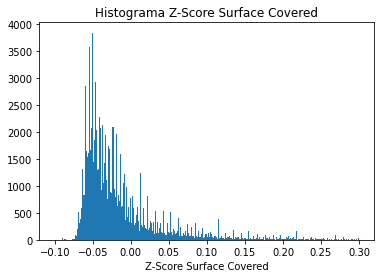

In [356]:
plt.hist(df.z_surface_covered, bins=300, range=(-0.1,0.3))
plt.title('Histograma Z-Score Surface Covered')
plt.xlabel('Z-Score Surface Covered')
plt.show()

##### Z-Score Modificado

In [357]:
mediana_surface_covered=np.nanmedian(df.property_surface_covered)
MAD=np.nanmedian(np.absolute(df.property_surface_covered-mediana_surface_covered))

df['zm_surface_covered']=(df.property_surface_covered - mediana_surface_covered)*0.6745/MAD

In [358]:
df[(df['zm_surface_covered']>3.5)]

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,operation,...,property_currency,property_title,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms,z_price,zm_price,z_surface_covered,zm_surface_covered
58,tgaK6Ibor1zLY5bvNxsXfw==,2021-09-09,2021-09-26,2021-09-09,-34.633730,-58.424729,Capital Federal,Boedo,Boedo,Venta,...,USD,VENTA CASA BOEDO LOCAL DEPARTAMENTOS HABITACI...,4.992871,4.7215,7.237343,5.3960,0.859260,4.141197,0.160041,6.272850
410,S8iZ1eflTJtt4bejzBVktw==,2021-09-09,2021-09-10,2021-09-09,-34.576741,-58.404830,Capital Federal,Palermo,Palermo Chico,Venta,...,USD,Departamento - Palermo Chico,1.510104,1.3490,1.867914,1.3490,7.764431,29.725680,0.320291,11.533950
411,FblpEe26U1lQkU5vRzAtmg==,2021-09-09,2021-09-09,2021-09-09,-34.576741,-58.404830,Capital Federal,Palermo,Palermo Chico,Venta,...,USD,Departamento - Palermo Chico,1.510104,1.3490,1.867914,1.3490,7.764431,29.725680,0.320291,11.533950
438,taPk4LSPMT26ftJm7/Bh6Q==,2021-09-09,2022-03-06,2021-09-09,-34.575053,-58.407958,Capital Federal,Palermo,Palermo Chico,Venta,...,USD,Torre Vignoli 282 metros . 3 suites . 2 cocheras,0.813550,0.6745,0.973010,0.6745,6.352010,24.492491,0.172368,6.677550
448,0Ui0Bm9reiNrJFdUfgXwiA==,2021-09-09,2022-01-27,2021-09-09,-34.577855,-58.408796,Capital Federal,Palermo,Palermo Chico,Venta,...,USD,Departamento de 5 ambientes con dependencia -...,1.510104,1.3490,1.867914,1.3490,3.056360,12.281715,0.211403,7.959100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459842,Y4PuRUaAW17tsLGwFTukhA==,2021-01-05,2021-01-09,2021-01-05,-34.628397,-58.437706,Capital Federal,Caballito,Caballito,Venta,...,USD,3 Ambientes Venta de Pozo Caballito Full Ameni...,0.116997,0.0000,0.078105,0.0000,-0.071212,0.693688,6.557734,216.312150
459847,zMligt7YdiayCjrfqlmbfg==,2021-01-05,2021-01-09,2021-01-05,-34.628247,-58.437696,Capital Federal,Caballito,Caballito,Venta,...,USD,4 Ambientes Venta de Pozo Caballito Full Ameni...,0.813550,0.6745,0.973010,0.6745,0.308598,2.100928,8.710844,286.999750
459849,+9w0GBZbuObF0Nw6AAtu2Q==,2021-01-05,2021-01-09,2021-01-05,-34.628282,-58.437803,Capital Federal,Caballito,Caballito,Venta,...,USD,3 Ambientes Venta de Pozo Caballito Full Ameni...,0.116997,0.0000,0.078105,0.0000,-0.183126,0.279034,6.042056,199.382200
459986,Pxz0dKZgWiL7odLclgK/vA==,2021-01-05,NaT,2021-01-05,-34.613000,-58.362117,Capital Federal,Puerto Madero,Puerto Madero,Venta,...,USD,Departamento en venta en Puerto Madero,0.116997,0.0000,0.078105,0.0000,1.769487,7.513697,0.076834,3.541125


In [359]:
df[(df['zm_surface_covered']<-3.5)]

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,operation,...,property_currency,property_title,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms,z_price,zm_price,z_surface_covered,zm_surface_covered


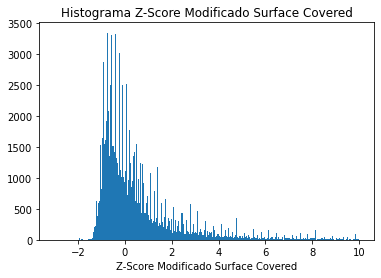

In [360]:
plt.hist(df.zm_surface_covered, bins=300, range=(-3,10))
plt.title('Histograma Z-Score Modificado Surface Covered')
plt.xlabel('Z-Score Modificado Surface Covered')
plt.show()

##### Características

Nuevamente, concluimos que al existir una gran masa conjunta de observaciones atípicas y una singular -también atípica- lejana a la masa en cuestión- podríamos decir que los outliers son del tipo colectivo (para la masa de observaciones cerca del máximo para el tercer cuartil) y global (para la observación singular por encima del resto de las observaciones).

#### Property surface total

##### Box plot

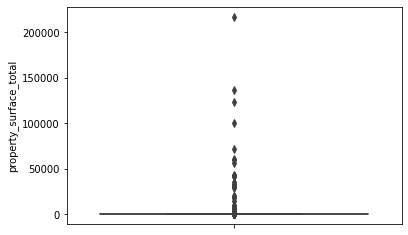

In [361]:
sns.boxplot(y=df.property_surface_total)
plt.show()

In [362]:
# Cuartiles
Q1_property_surface_covered=df.describe().get("property_surface_covered").get("25%")
Q3_property_surface_covered=df.describe().get("property_surface_covered").get("75%")

print("El valor de Q1 es:", Q1_property_surface_covered)
print("El valor de Q3 es:", Q3_property_surface_covered)

# Rango intercuartil
IQR_property_surface_covered=Q3_property_surface_covered-Q1_property_surface_covered

# Limites Outliers
out_inf=Q1_property_surface_covered-1.5*IQR_property_surface_covered
out_sup=Q3_property_surface_covered+1.5*IQR_property_surface_covered
print("El limite inferior del Q1 es:", out_inf)
print("El limite superior del Q3 es:", out_sup)

El valor de Q1 es: 40.0
El valor de Q3 es: 89.0
El limite inferior del Q1 es: -33.5
El limite superior del Q3 es: 162.5


Confirmamos que tratamos con un outlier

In [363]:
outlier=df[df['property_surface_covered']>out_sup]
outlier

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,operation,...,property_currency,property_title,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms,z_price,zm_price,z_surface_covered,zm_surface_covered
58,tgaK6Ibor1zLY5bvNxsXfw==,2021-09-09,2021-09-26,2021-09-09,-34.633730,-58.424729,Capital Federal,Boedo,Boedo,Venta,...,USD,VENTA CASA BOEDO LOCAL DEPARTAMENTOS HABITACI...,4.992871,4.7215,7.237343,5.3960,0.859260,4.141197,0.160041,6.272850
410,S8iZ1eflTJtt4bejzBVktw==,2021-09-09,2021-09-10,2021-09-09,-34.576741,-58.404830,Capital Federal,Palermo,Palermo Chico,Venta,...,USD,Departamento - Palermo Chico,1.510104,1.3490,1.867914,1.3490,7.764431,29.725680,0.320291,11.533950
411,FblpEe26U1lQkU5vRzAtmg==,2021-09-09,2021-09-09,2021-09-09,-34.576741,-58.404830,Capital Federal,Palermo,Palermo Chico,Venta,...,USD,Departamento - Palermo Chico,1.510104,1.3490,1.867914,1.3490,7.764431,29.725680,0.320291,11.533950
438,taPk4LSPMT26ftJm7/Bh6Q==,2021-09-09,2022-03-06,2021-09-09,-34.575053,-58.407958,Capital Federal,Palermo,Palermo Chico,Venta,...,USD,Torre Vignoli 282 metros . 3 suites . 2 cocheras,0.813550,0.6745,0.973010,0.6745,6.352010,24.492491,0.172368,6.677550
448,0Ui0Bm9reiNrJFdUfgXwiA==,2021-09-09,2022-01-27,2021-09-09,-34.577855,-58.408796,Capital Federal,Palermo,Palermo Chico,Venta,...,USD,Departamento de 5 ambientes con dependencia -...,1.510104,1.3490,1.867914,1.3490,3.056360,12.281715,0.211403,7.959100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459842,Y4PuRUaAW17tsLGwFTukhA==,2021-01-05,2021-01-09,2021-01-05,-34.628397,-58.437706,Capital Federal,Caballito,Caballito,Venta,...,USD,3 Ambientes Venta de Pozo Caballito Full Ameni...,0.116997,0.0000,0.078105,0.0000,-0.071212,0.693688,6.557734,216.312150
459847,zMligt7YdiayCjrfqlmbfg==,2021-01-05,2021-01-09,2021-01-05,-34.628247,-58.437696,Capital Federal,Caballito,Caballito,Venta,...,USD,4 Ambientes Venta de Pozo Caballito Full Ameni...,0.813550,0.6745,0.973010,0.6745,0.308598,2.100928,8.710844,286.999750
459849,+9w0GBZbuObF0Nw6AAtu2Q==,2021-01-05,2021-01-09,2021-01-05,-34.628282,-58.437803,Capital Federal,Caballito,Caballito,Venta,...,USD,3 Ambientes Venta de Pozo Caballito Full Ameni...,0.116997,0.0000,0.078105,0.0000,-0.183126,0.279034,6.042056,199.382200
459986,Pxz0dKZgWiL7odLclgK/vA==,2021-01-05,NaT,2021-01-05,-34.613000,-58.362117,Capital Federal,Puerto Madero,Puerto Madero,Venta,...,USD,Departamento en venta en Puerto Madero,0.116997,0.0000,0.078105,0.0000,1.769487,7.513697,0.076834,3.541125


##### Z-Score

In [364]:
media_surface_total=np.mean(df.property_surface_total)
std_surface_total=np.std(df.property_surface_total)
df['z_surface_total']=(df.property_surface_total - media_surface_total)/std_surface_total

In [365]:
df[df['z_surface_total']>3]

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,operation,...,property_title,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms,z_price,zm_price,z_surface_covered,zm_surface_covered,z_surface_total
1140,ddV7Ll5c1H+Rmqqovc+uFg==,2021-09-09,2022-01-27,2021-09-09,-34.605781,-58.376705,Capital Federal,San Nicolás,San Nicolás,Venta,...,EDIFICIO A TERMINAR DE 900M2- EXCELENTE UBICAC...,NaN,NaN,NaN,NaN,30.363174,113.456715,10.695485,352.156450,8.745611
1932,eQ/SiyES/mXWsSyAzb3k3A==,2021-12-17,NaT,2021-12-17,-34.637026,-58.426283,Capital Federal,Parque Chacabuco,Parque Chacabuco,Venta,...,EXCEPCIONAL CASA DOS FAMILIAS - Parque Chacabuco,NaN,NaN,NaN,NaN,0.074581,1.233870,222.821967,7316.368950,182.568661
33017,UzV402bMqMRezkA/xEyQ1w==,2021-02-08,NaT,2021-02-08,-34.634196,-58.465152,Capital Federal,Flores,Flores,Venta,...,Departamento - Flores,-1.276110,-1.3490,-0.816800,-0.6745,-0.526319,-0.992538,-0.058763,-0.910575,3.634455
34123,Kr2fYXhFuQz9vuxKD2btYw==,2021-02-08,2021-05-01,2021-02-08,-34.557903,-58.452293,Capital Federal,Belgrano,Belgrano,Venta,...,VENTA DEPARTAMENTO 3-4 AMBIENTES COCHERA BELG...,0.813550,0.6745,0.973010,0.6745,0.601885,3.187594,0.021362,1.719975,4.115941
72316,BPTyNzwU2D4btCduu8ls3A==,2021-05-29,2021-06-08,2021-05-29,-34.578917,-58.429373,Capital Federal,Palermo,Palermo,Venta,...,VENTA DEPARTAMENTO 2 AMBIENTES PALERMO C/AMENI...,-0.579557,-0.6745,-0.816800,-0.6745,-0.003886,0.943137,54.384295,1786.480700,51.363824
72521,csbBJk04jQXgGZLXTj5WAg==,2021-05-29,2021-06-13,2021-05-29,-34.600113,-58.403649,Capital Federal,Balvanera,Balvanera,Venta,...,VENTA 2 AMBIENTES CON RENTA,-0.579557,-0.6745,-0.816800,-0.6745,-0.502942,-0.905923,32.442301,1066.114700,28.358575
84073,vMD1fCSS0kedOs8Bk/PCjA==,2021-02-05,2021-05-16,2021-02-05,-34.588175,-58.396261,Capital Federal,Recoleta,Recoleta,Venta,...,Departamento Monoambiente alquiler temporario ...,-1.276110,-1.3490,-0.816800,-0.6745,-0.427613,-0.626820,-0.059790,-0.944300,30.210442
94789,jXPtdq0ibrnXyePLhTi27g==,2021-09-24,2021-09-26,2021-09-24,-34.614279,-58.361092,Capital Federal,Caballito,Caballito,Venta,...,VENTA - EMPRENDIMIENTO DEPARTAMENTO 2 AMBIENTES,-0.579557,-0.6745,-0.816800,-0.6745,-0.254984,0.012792,4.849423,160.227475,4.378569
106598,+YPtNPAzbhoDCLgqF26Q8A==,2021-03-11,2021-04-20,2021-03-11,-34.587320,-58.401556,Capital Federal,Barrio Norte,Barrio Norte,Venta,...,EXCELENTE DEPARTAMENTO DE 2 AMBIENTES DE CATEG...,-0.579557,-0.6745,-0.816800,-0.6745,-0.160822,0.361672,53.880944,1769.955450,47.668506
117835,vyRPw0ch6cIj9Ki5yPUneA==,2021-08-18,2021-08-23,2021-08-18,-34.550093,-58.483034,Capital Federal,Saavedra,Saavedra,Venta,...,"Venta Departamento 2 amb a Estrenar, Saavedra.",-0.579557,-0.6745,-0.816800,-0.6745,-0.352284,-0.347716,41.038303,1348.325500,36.175140


In [366]:
df[df['z_surface_covered']<-3]

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,operation,...,property_title,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms,z_price,zm_price,z_surface_covered,zm_surface_covered,z_surface_total


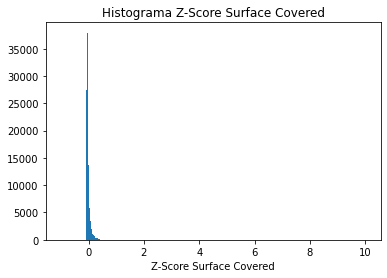

In [367]:
plt.hist(df.z_surface_covered, bins=300, range=(-1,10))
plt.title('Histograma Z-Score Surface Covered')
plt.xlabel('Z-Score Surface Covered')
plt.show()

##### Z-Score Modificado

In [368]:
mediana_surface_total=np.nanmedian(df.property_surface_total)
MAD=np.nanmedian(np.absolute(df.property_surface_total-mediana_surface_total))

df['zm_surface_total']=(df.property_surface_total - mediana_surface_total)*0.6745/MAD

In [369]:
df[(df['zm_surface_total']>3.5)]

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,operation,...,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms,z_price,zm_price,z_surface_covered,zm_surface_covered,z_surface_total,zm_surface_total
58,tgaK6Ibor1zLY5bvNxsXfw==,2021-09-09,2021-09-26,2021-09-09,-34.633730,-58.424729,Capital Federal,Boedo,Boedo,Venta,...,4.992871,4.7215,7.237343,5.3960,0.859260,4.141197,0.160041,6.272850,0.238803,8.87642
410,S8iZ1eflTJtt4bejzBVktw==,2021-09-09,2021-09-10,2021-09-09,-34.576741,-58.404830,Capital Federal,Palermo,Palermo Chico,Venta,...,1.510104,1.3490,1.867914,1.3490,7.764431,29.725680,0.320291,11.533950,0.243854,9.03830
411,FblpEe26U1lQkU5vRzAtmg==,2021-09-09,2021-09-09,2021-09-09,-34.576741,-58.404830,Capital Federal,Palermo,Palermo Chico,Venta,...,1.510104,1.3490,1.867914,1.3490,7.764431,29.725680,0.320291,11.533950,0.243854,9.03830
438,taPk4LSPMT26ftJm7/Bh6Q==,2021-09-09,2022-03-06,2021-09-09,-34.575053,-58.407958,Capital Federal,Palermo,Palermo Chico,Venta,...,0.813550,0.6745,0.973010,0.6745,6.352010,24.492491,0.172368,6.677550,0.144526,5.85466
448,0Ui0Bm9reiNrJFdUfgXwiA==,2021-09-09,2022-01-27,2021-09-09,-34.577855,-58.408796,Capital Federal,Palermo,Palermo Chico,Venta,...,1.510104,1.3490,1.867914,1.3490,3.056360,12.281715,0.211403,7.959100,0.163045,6.44822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459841,9aQHQRqWMburSn+z+Qt5aQ==,2021-01-05,2021-01-09,2021-01-05,-34.627876,-58.437996,Capital Federal,Caballito,Caballito,Venta,...,0.116997,0.0000,0.078105,0.0000,-0.152012,0.394315,7.257289,239.278875,5.928246,191.23424
459842,Y4PuRUaAW17tsLGwFTukhA==,2021-01-05,2021-01-09,2021-01-05,-34.628397,-58.437706,Capital Federal,Caballito,Caballito,Venta,...,0.116997,0.0000,0.078105,0.0000,-0.071212,0.693688,6.557734,216.312150,6.755694,217.75558
459847,zMligt7YdiayCjrfqlmbfg==,2021-01-05,2021-01-09,2021-01-05,-34.628247,-58.437696,Capital Federal,Caballito,Caballito,Venta,...,0.813550,0.6745,0.973010,0.6745,0.308598,2.100928,8.710844,286.999750,15.139605,486.47638
459849,+9w0GBZbuObF0Nw6AAtu2Q==,2021-01-05,2021-01-09,2021-01-05,-34.628282,-58.437803,Capital Federal,Caballito,Caballito,Venta,...,0.116997,0.0000,0.078105,0.0000,-0.183126,0.279034,6.042056,199.382200,6.405523,206.53190


In [370]:
df[(df['zm_surface_covered']<-3.5)]

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,operation,...,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms,z_price,zm_price,z_surface_covered,zm_surface_covered,z_surface_total,zm_surface_total


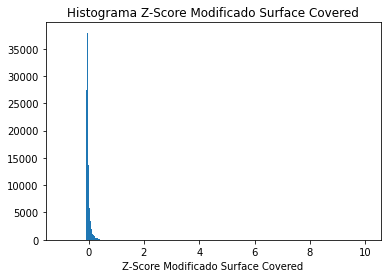

In [371]:
plt.hist(df.z_surface_covered, bins=300, range=(-1,10))
plt.title('Histograma Z-Score Modificado Surface Covered')
plt.xlabel('Z-Score Modificado Surface Covered')
plt.show()

##### Características

Nuevamente, concluimos que al existir una gran masa conjunta de observaciones atípicas y una singular -también atípica- lejana a la masa en cuestión- podríamos decir que los outliers son del tipo colectivo (para la masa de observaciones cerca del máximo para el tercer cuartil) y global (para la observación singular por encima del resto de las observaciones).

### Outliers multivariados

---

Para el análisis de outliers de tipo multivariados estaremos utilizando el método de Mahalanobis el cual nos brinda información respecto de la distancia de las observaciones agrupando las similares en clusters, evidenciando así los puntos aislados que pasaremos a considerar como valores atípicos.

Por último, podremos destacar cuáles son las características de los valores en cuestión pudiendo clasificar los mismos en: global, contextual y colectivo.

#### Preparación del dataset para el estudio de Mahalanobis

Para la utilización del método, analizamos la presencia de valores `nan` en nuestro dataset y analizamos la posibilidad de descartar los mismos en caso de existir nulos.

In [372]:
mahal = df.copy()
mahal.isnull().sum()

id                             0
start_date                     0
end_date                    5041
created_on                     0
latitud                        0
longitud                       0
place_l2                       0
place_l3                       0
place_l4                       0
operation                      0
property_type                  0
property_rooms               432
property_bedrooms            433
property_surface_total         0
property_surface_covered       0
property_price                 0
property_currency              0
property_title                 0
z_rooms                      432
zm_rooms                     432
z_bedrooms                   433
zm_bedrooms                  433
z_price                        0
zm_price                       0
z_surface_covered              0
zm_surface_covered             0
z_surface_total                0
zm_surface_total               0
dtype: int64

Procedemos a eliminar los registros en cuestión dado que representan una pequeña porción del dataset y no se verán afectados los resultados.

In [373]:
mahal.dropna(subset=['property_rooms', 'property_bedrooms'], inplace = True)
mahal.isnull().sum()

id                             0
start_date                     0
end_date                    5005
created_on                     0
latitud                        0
longitud                       0
place_l2                       0
place_l3                       0
place_l4                       0
operation                      0
property_type                  0
property_rooms                 0
property_bedrooms              0
property_surface_total         0
property_surface_covered       0
property_price                 0
property_currency              0
property_title                 0
z_rooms                        0
zm_rooms                       0
z_bedrooms                     0
zm_bedrooms                    0
z_price                        0
zm_price                       0
z_surface_covered              0
zm_surface_covered             0
z_surface_total                0
zm_surface_total               0
dtype: int64

#### Property surface total vs Price



##### Scatter


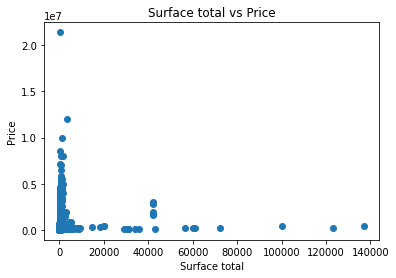

In [374]:
plt.scatter(mahal.property_surface_total,mahal.property_price)
plt.title('Surface total vs Price')
plt.xlabel('Surface total')
plt.ylabel('Price')
plt.show()

##### Mahalanobis

In [375]:
X = mahal[['property_surface_total','property_price']] # Tomamos las columnas a comparar
sample_X = X.sample(frac=0.1) # Retorna una muestra de los datos

mu = sample_X.mean() # Calculamos la media
X_diff = X - mu
X_diff = X_diff.values.T

cov = np.cov(sample_X.values.T) # Calculamos la matriz de covarianza
inv_cov = np.linalg.inv(cov) # Le calculamos su inversa
W = sc.linalg.sqrtm(inv_cov) # Tomamos raiz cuadrada 

Wx = np.matmul(W, X_diff) # Hacemos el producto de ambas matrices

mahal['mahal_sfto_prc'] = np.array([np.dot(Wx[:, i], Wx[:, i]) for i in range(Wx.shape[1])])

mahal.head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,operation,...,zm_rooms,z_bedrooms,zm_bedrooms,z_price,zm_price,z_surface_covered,zm_surface_covered,z_surface_total,zm_surface_total,mahal_sfto_prc
25,CyZu6IaZgmQYGk8jmPajCg==,2021-09-09,2021-09-26,2021-09-09,-32.966425,-60.857846,Capital Federal,Capital Federal,Capital Federal,Venta,...,0.6745,0.973010,0.6745,-0.050967,0.768697,0.046016,2.529375,0.051091,2.85988,0.005812
42,d3Z0MblSb2IMBoOBMGJEEQ==,2021-09-09,2021-09-26,2021-09-09,-34.637319,-58.361124,Capital Federal,Boca,Boca,Venta,...,0.0000,0.078105,0.0000,-0.449898,-0.709388,-0.034109,-0.101175,-0.044028,-0.18886,0.190988
43,rL7qPkQnomsMGu2ViS3sBw==,2021-09-09,2021-09-28,2021-09-09,-34.628647,-58.361871,Capital Federal,Boca,Boca,Venta,...,0.6745,0.973010,0.6745,-0.399364,-0.522156,-0.018700,0.404700,-0.033927,0.13490,0.150640
49,vuX/ccLAMVml4qWRFcOJUA==,2021-09-09,2022-01-05,2021-09-09,-34.610027,-58.401934,Capital Federal,Once,Once,Venta,...,0.6745,0.078105,0.0000,-0.251845,0.024422,0.016226,1.551350,-0.005307,1.05222,0.060502
51,ZTtSCeqZ3HUgf5jjwEzRcw==,2021-09-09,2022-03-09,2021-09-09,-34.631621,-58.416825,Capital Federal,Boedo,Boedo,Venta,...,0.6745,0.078105,0.0000,0.074581,1.233870,-0.015619,0.505875,-0.031401,0.21584,0.007475


In [376]:
np.sort(mahal.mahal_sfto_prc) # Ordenamos distancias calculadas de menor a mayor

array([4.61571076e-06, 4.82923514e-06, 9.13005981e-06, ...,
       8.66911409e+03, 1.31288766e+04, 1.62685897e+04])

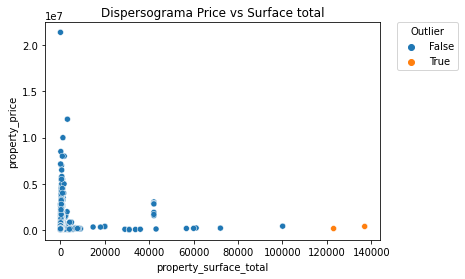

In [377]:
umbral=10000
mahal[mahal['mahal_sfto_prc']>umbral] # Observaciones anómalas

es_outlier = (mahal['mahal_sfto_prc'] > umbral)

sns.scatterplot(x=mahal.property_surface_total,y=mahal.property_price, hue=es_outlier) #Grafico scatter
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title="Outlier")
plt.title('Dispersograma Price vs Surface total')
plt.show()

##### Caracteristicas

Podemos visualizar que los valores que se encuentran particularmente alejados de la masa de observaciones caben dentro de la clasificación de outliers globales.

#### Property rooms vs Property bedrooms

##### Scatter

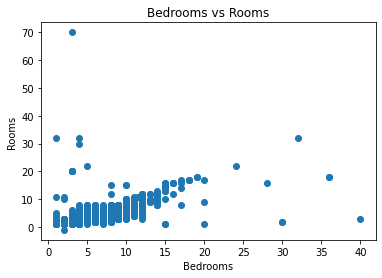

In [378]:
plt.scatter(mahal.property_rooms,mahal.property_bedrooms)
plt.title('Bedrooms vs Rooms')
plt.xlabel('Bedrooms')
plt.ylabel('Rooms')
plt.show()

##### Mahalanobis

In [379]:
X = mahal[['property_rooms','property_bedrooms']] # Tomamos las columnas a comparar
sample_X = X.sample(frac=0.1) # Retorna una muestra de los datos

mu = sample_X.mean() # Calculamos la media
X_diff = X - mu
X_diff = X_diff.values.T

cov = np.cov(sample_X.values.T) # Calculamos la matriz de covarianza
inv_cov = np.linalg.inv(cov) # Le calculamos su inversa
W = sc.linalg.sqrtm(inv_cov) # Tomamos raiz cuadrada 

Wx = np.matmul(W, X_diff) # Hacemos el producto de ambas matrices

mahal['mahal_ro_bdro'] = np.array([np.dot(Wx[:, i], Wx[:, i]) for i in range(Wx.shape[1])])

mahal.head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,operation,...,z_bedrooms,zm_bedrooms,z_price,zm_price,z_surface_covered,zm_surface_covered,z_surface_total,zm_surface_total,mahal_sfto_prc,mahal_ro_bdro
25,CyZu6IaZgmQYGk8jmPajCg==,2021-09-09,2021-09-26,2021-09-09,-32.966425,-60.857846,Capital Federal,Capital Federal,Capital Federal,Venta,...,0.973010,0.6745,-0.050967,0.768697,0.046016,2.529375,0.051091,2.85988,0.005812,0.803711
42,d3Z0MblSb2IMBoOBMGJEEQ==,2021-09-09,2021-09-26,2021-09-09,-34.637319,-58.361124,Capital Federal,Boca,Boca,Venta,...,0.078105,0.0000,-0.449898,-0.709388,-0.034109,-0.101175,-0.044028,-0.18886,0.190988,0.016228
43,rL7qPkQnomsMGu2ViS3sBw==,2021-09-09,2021-09-28,2021-09-09,-34.628647,-58.361871,Capital Federal,Boca,Boca,Venta,...,0.973010,0.6745,-0.399364,-0.522156,-0.018700,0.404700,-0.033927,0.13490,0.150640,0.803711
49,vuX/ccLAMVml4qWRFcOJUA==,2021-09-09,2022-01-05,2021-09-09,-34.610027,-58.401934,Capital Federal,Once,Once,Venta,...,0.078105,0.0000,-0.251845,0.024422,0.016226,1.551350,-0.005307,1.05222,0.060502,1.380960
51,ZTtSCeqZ3HUgf5jjwEzRcw==,2021-09-09,2022-03-09,2021-09-09,-34.631621,-58.416825,Capital Federal,Boedo,Boedo,Venta,...,0.078105,0.0000,0.074581,1.233870,-0.015619,0.505875,-0.031401,0.21584,0.007475,1.380960


In [380]:
np.sort(mahal.mahal_ro_bdro) # Ordenamos distancias calculadas de menor a mayor

array([1.62280981e-02, 1.62280981e-02, 1.62280981e-02, ...,
       1.36786579e+03, 1.50190678e+03, 6.42832785e+03])

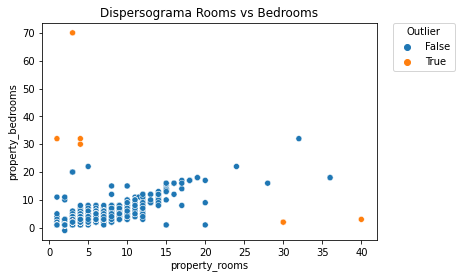

In [381]:
umbral=700
mahal[mahal['mahal_ro_bdro']>umbral] # Observaciones anómalas

es_outlier = (mahal['mahal_ro_bdro'] > umbral)

sns.scatterplot(x=mahal.property_rooms,y=mahal.property_bedrooms, hue=es_outlier) #Grafico scatter
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title="Outlier")
plt.title('Dispersograma Rooms vs Bedrooms')
plt.show()

##### Caracteristicas

Notamos que estamos en presencia de outliers en su mayoría globales, con la particularidad de que tenemos algunos casos de valores atípicos colectivos en las cercanías del rango equivalente a 30 respecto del eje `property_bedrooms`.

Adicionalmente, cabe destacar que hay dos valores particularmente alejados. Siguiendo esta línea, llegamos a la conclusión de que estamos en presencia de outliers globales.

#### Property rooms vs Property surface total

##### Scatter


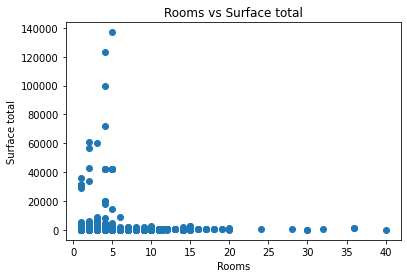

In [382]:
plt.scatter(mahal.property_rooms,mahal.property_surface_total)
plt.title('Rooms vs Surface total')
plt.xlabel('Rooms')
plt.ylabel('Surface total')
plt.show()

##### Mahalanobis

Para poder determinar concretamente estos valores atipicos, nos ayudamos con el calculo de la distancia de mahalanobis para cada una de las observaciones presentes.

In [383]:
X = mahal[['property_rooms','property_surface_total']] # Tomamos las columnas a comparar
sample_X = X.sample(frac=0.1) # Retorna una muestra de los datos

mu = sample_X.mean() # Calculamos la media
X_diff = X - mu
X_diff = X_diff.values.T

cov = np.cov(sample_X.values.T) # Calculamos la matriz de covarianza
inv_cov = np.linalg.inv(cov) # Le calculamos su inversa
W = sc.linalg.sqrtm(inv_cov) # Tomamos raiz cuadrada 

Wx = np.matmul(W, X_diff) # Hacemos el producto de ambas matrices

mahal['mahal_ro_sfto'] = np.array([np.dot(Wx[:, i], Wx[:, i]) for i in range(Wx.shape[1])])

mahal.head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,operation,...,zm_bedrooms,z_price,zm_price,z_surface_covered,zm_surface_covered,z_surface_total,zm_surface_total,mahal_sfto_prc,mahal_ro_bdro,mahal_ro_sfto
25,CyZu6IaZgmQYGk8jmPajCg==,2021-09-09,2021-09-26,2021-09-09,-32.966425,-60.857846,Capital Federal,Capital Federal,Capital Federal,Venta,...,0.6745,-0.050967,0.768697,0.046016,2.529375,0.051091,2.85988,0.005812,0.803711,0.639397
42,d3Z0MblSb2IMBoOBMGJEEQ==,2021-09-09,2021-09-26,2021-09-09,-34.637319,-58.361124,Capital Federal,Boca,Boca,Venta,...,0.0000,-0.449898,-0.709388,-0.034109,-0.101175,-0.044028,-0.18886,0.190988,0.016228,0.014903
43,rL7qPkQnomsMGu2ViS3sBw==,2021-09-09,2021-09-28,2021-09-09,-34.628647,-58.361871,Capital Federal,Boca,Boca,Venta,...,0.6745,-0.399364,-0.522156,-0.018700,0.404700,-0.033927,0.13490,0.150640,0.803711,0.644300
49,vuX/ccLAMVml4qWRFcOJUA==,2021-09-09,2022-01-05,2021-09-09,-34.610027,-58.401934,Capital Federal,Once,Once,Venta,...,0.0000,-0.251845,0.024422,0.016226,1.551350,-0.005307,1.05222,0.060502,1.380960,0.641908
51,ZTtSCeqZ3HUgf5jjwEzRcw==,2021-09-09,2022-03-09,2021-09-09,-34.631621,-58.416825,Capital Federal,Boedo,Boedo,Venta,...,0.0000,0.074581,1.233870,-0.015619,0.505875,-0.031401,0.21584,0.007475,1.380960,0.644059


In [384]:
np.sort(mahal.mahal_ro_sfto) # Ordenamos distancias calculadas de menor a mayor

array([1.27648183e-02, 1.27648183e-02, 1.27648183e-02, ...,
       3.24821855e+03, 4.91080061e+03, 6.09073094e+03])

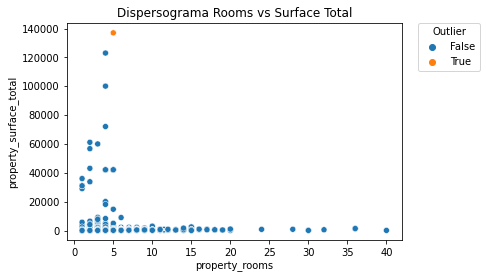

In [385]:
umbral=5000
mahal[mahal['mahal_ro_sfto']>umbral] # Observaciones anómalas

es_outlier = (mahal['mahal_ro_sfto'] > umbral)

sns.scatterplot(x=mahal.property_rooms,y=mahal.property_surface_total, hue=es_outlier) #Grafico scatter
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title="Outlier")
plt.title('Dispersograma Rooms vs Surface Total')
plt.show()

##### Caracteristicas

En esta nueva comparación, contamos -una vez más- con la presencia de registros aislados en la parte superior izquierda que podríamos clasificarlos como outliers globales.

#### Property rooms vs Property surface covered

##### Scatter

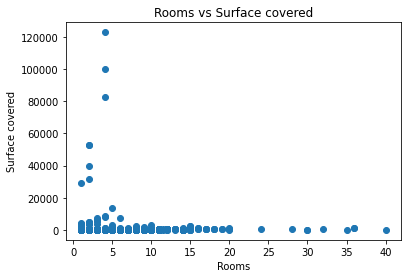

In [386]:
plt.scatter(df.property_rooms,df.property_surface_covered)
plt.title('Rooms vs Surface covered')
plt.xlabel('Rooms')
plt.ylabel('Surface covered')
plt.show()

##### Mahalanobis

In [387]:
X = mahal[['property_rooms','property_surface_covered']] # Tomamos las columnas a comparar
sample_X = X.sample(frac=0.1) # Retorna una muestra de los datos

mu = sample_X.mean() # Calculamos la media
X_diff = X - mu
X_diff = X_diff.values.T

cov = np.cov(sample_X.values.T) # Calculamos la matriz de covarianza
inv_cov = np.linalg.inv(cov) # Le calculamos su inversa
W = sc.linalg.sqrtm(inv_cov) # Tomamos raiz cuadrada 

Wx = np.matmul(W, X_diff) # Hacemos el producto de ambas matrices

mahal['mahal_ro_sfcv'] = np.array([np.dot(Wx[:, i], Wx[:, i]) for i in range(Wx.shape[1])])

mahal.head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,operation,...,z_price,zm_price,z_surface_covered,zm_surface_covered,z_surface_total,zm_surface_total,mahal_sfto_prc,mahal_ro_bdro,mahal_ro_sfto,mahal_ro_sfcv
25,CyZu6IaZgmQYGk8jmPajCg==,2021-09-09,2021-09-26,2021-09-09,-32.966425,-60.857846,Capital Federal,Capital Federal,Capital Federal,Venta,...,-0.050967,0.768697,0.046016,2.529375,0.051091,2.85988,0.005812,0.803711,0.639397,0.700664
42,d3Z0MblSb2IMBoOBMGJEEQ==,2021-09-09,2021-09-26,2021-09-09,-34.637319,-58.361124,Capital Federal,Boca,Boca,Venta,...,-0.449898,-0.709388,-0.034109,-0.101175,-0.044028,-0.18886,0.190988,0.016228,0.014903,0.019160
43,rL7qPkQnomsMGu2ViS3sBw==,2021-09-09,2021-09-28,2021-09-09,-34.628647,-58.361871,Capital Federal,Boca,Boca,Venta,...,-0.399364,-0.522156,-0.018700,0.404700,-0.033927,0.13490,0.150640,0.803711,0.644300,0.707586
49,vuX/ccLAMVml4qWRFcOJUA==,2021-09-09,2022-01-05,2021-09-09,-34.610027,-58.401934,Capital Federal,Once,Once,Venta,...,-0.251845,0.024422,0.016226,1.551350,-0.005307,1.05222,0.060502,1.380960,0.641908,0.701735
51,ZTtSCeqZ3HUgf5jjwEzRcw==,2021-09-09,2022-03-09,2021-09-09,-34.631621,-58.416825,Capital Federal,Boedo,Boedo,Venta,...,0.074581,1.233870,-0.015619,0.505875,-0.031401,0.21584,0.007475,1.380960,0.644059,0.706871


In [388]:
np.sort(mahal.mahal_ro_sfcv) # Ordenamos distancias calculadas de menor a mayor

array([1.58017603e-02, 1.58017603e-02, 1.58017603e-02, ...,
       1.47385742e+04, 2.14270663e+04, 3.23989828e+04])

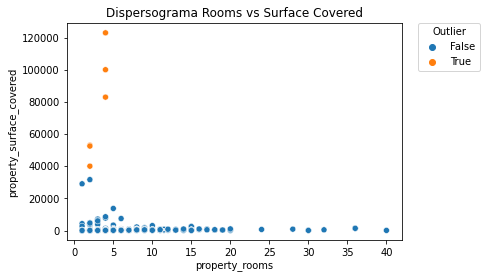

In [389]:
umbral=3000
mahal[mahal['mahal_ro_sfcv']>umbral] # Observaciones anómalas

es_outlier = (mahal['mahal_ro_sfcv'] > umbral)

sns.scatterplot(x=mahal.property_rooms,y=mahal.property_surface_covered, hue=es_outlier) #Grafico scatter
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title="Outlier")
plt.title('Dispersograma Rooms vs Surface Covered')
plt.show()

##### Caracteristicas

Luego de la comparación de surface covered vs property rooms, notamos que nuevamente estamos en presencia de outliers, en particular esta vez todos de carácter global.


#### Property rooms vs Property price

##### Scatter

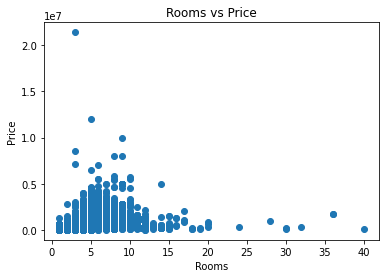

In [390]:
plt.scatter(mahal.property_rooms,mahal.property_price)
plt.title('Rooms vs Price')
plt.xlabel('Rooms')
plt.ylabel('Price')
plt.show()

##### Mahalanobis

In [391]:
X = mahal[['property_rooms','property_price']] # Tomamos las columnas a comparar
sample_X = X.sample(frac=0.1) # Retorna una muestra de los datos

mu = sample_X.mean() # Calculamos la media
X_diff = X - mu
X_diff = X_diff.values.T

cov = np.cov(sample_X.values.T) # Calculamos la matriz de covarianza
inv_cov = np.linalg.inv(cov) # Le calculamos su inversa
W = sc.linalg.sqrtm(inv_cov) # Tomamos raiz cuadrada 

Wx = np.matmul(W, X_diff) # Hacemos el producto de ambas matrices

mahal['mahal_ro_pr'] = np.array([np.dot(Wx[:, i], Wx[:, i]) for i in range(Wx.shape[1])])

mahal.head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,operation,...,zm_price,z_surface_covered,zm_surface_covered,z_surface_total,zm_surface_total,mahal_sfto_prc,mahal_ro_bdro,mahal_ro_sfto,mahal_ro_sfcv,mahal_ro_pr
25,CyZu6IaZgmQYGk8jmPajCg==,2021-09-09,2021-09-26,2021-09-09,-32.966425,-60.857846,Capital Federal,Capital Federal,Capital Federal,Venta,...,0.768697,0.046016,2.529375,0.051091,2.85988,0.005812,0.803711,0.639397,0.700664,1.023568
42,d3Z0MblSb2IMBoOBMGJEEQ==,2021-09-09,2021-09-26,2021-09-09,-34.637319,-58.361124,Capital Federal,Boca,Boca,Venta,...,-0.709388,-0.034109,-0.101175,-0.044028,-0.18886,0.190988,0.016228,0.014903,0.019160,0.368596
43,rL7qPkQnomsMGu2ViS3sBw==,2021-09-09,2021-09-28,2021-09-09,-34.628647,-58.361871,Capital Federal,Boca,Boca,Venta,...,-0.522156,-0.018700,0.404700,-0.033927,0.13490,0.150640,0.803711,0.644300,0.707586,1.632481
49,vuX/ccLAMVml4qWRFcOJUA==,2021-09-09,2022-01-05,2021-09-09,-34.610027,-58.401934,Capital Federal,Once,Once,Venta,...,0.024422,0.016226,1.551350,-0.005307,1.05222,0.060502,1.380960,0.641908,0.701735,1.335546
51,ZTtSCeqZ3HUgf5jjwEzRcw==,2021-09-09,2022-03-09,2021-09-09,-34.631621,-58.416825,Capital Federal,Boedo,Boedo,Venta,...,1.233870,-0.015619,0.505875,-0.031401,0.21584,0.007475,1.380960,0.644059,0.706871,0.882666


In [392]:
np.sort(mahal.mahal_ro_pr) # Ordenamos distancias calculadas de menor a mayor

array([1.70589676e-02, 1.70601081e-02, 1.70601081e-02, ...,
       1.08272667e+03, 1.72669863e+03, 5.81711280e+03])

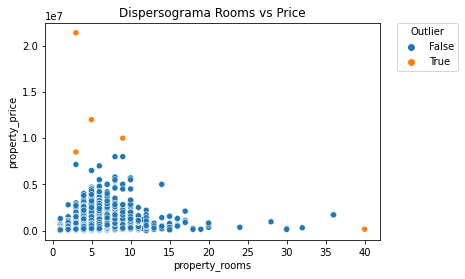

In [393]:
umbral=700
mahal[mahal['mahal_ro_pr']>umbral] # Observaciones anómalas

es_outlier = (mahal['mahal_ro_pr'] > umbral)

sns.scatterplot(x=mahal.property_rooms,y=mahal.property_price, hue=es_outlier) #Grafico scatter
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title="Outlier")
plt.title('Dispersograma Rooms vs Price')
plt.show()

##### Caracteristicas

Nuevamente visualizamos outliers globales.

### Tratamiento

Para cada una de las variables, estudiamos si es posible eliminar los valores atípicos encontrados con los métodos previamente descriptos analizando la proporción que estos representan sobre el total de los valores, teniendo en cuenta la decisión de admitir una tolerancia del 10% de otuliers.

#### Property rooms

In [394]:
rooms_outliers_porcentaje = df[(df['zm_rooms']>3.5)].shape[0]/df['zm_rooms'].shape[0]*100

print(f"Los valores atípicos encontrados para property_rooms representan un {round(rooms_outliers_porcentaje, 3)}% del total del dataset.")

Los valores atípicos encontrados para property_rooms representan un 0.429% del total del dataset.


Eliminamos los outliers del dataset:

In [395]:
df.drop(df[df['zm_rooms']>3.5].index, inplace=True)

#### Property bedrooms

In [396]:
bedrooms_outliers_porcentaje = df[(df['zm_bedrooms']>3.5)].shape[0]/df['zm_bedrooms'].shape[0]*100

print(f"Los valores atípicos encontrados para property_bedrooms representan un {round(bedrooms_outliers_porcentaje, 3)}% del total del dataset.")

Los valores atípicos encontrados para property_bedrooms representan un 0.033% del total del dataset.


In [397]:
df.drop(df[df['zm_bedrooms']>3.5].index, inplace=True)

#### Property price

In [398]:
price_outliers_porcentaje = df[(df['zm_price']>3.5)].shape[0]/df['zm_price'].shape[0]*100

print(f"Los valores atípicos encontrados para property_price representan un {round(price_outliers_porcentaje, 3)}% del total del dataset.")

Los valores atípicos encontrados para property_price representan un 8.911% del total del dataset.


In [399]:
df.drop(df[df['zm_price']>3.5].index, inplace=True)

#### Property surface covered

In [403]:
surface_covered_outliers_porcentaje = df[(df['zm_surface_covered']>3.5)].shape[0]/df['zm_surface_covered'].shape[0]*100

print(f"Los valores atípicos encontrados para property_surface_covered representan un {round(surface_covered_outliers_porcentaje, 3)}% del total del dataset.")

Los valores atípicos encontrados para property_surface_covered representan un 2.658% del total del dataset.


In [404]:
df.drop(df[df['zm_surface_covered']>3.5].index, inplace=True)

#### Property surface total

In [405]:
surface_total_outliers_porcentaje = df[(df['zm_surface_total']>3.5)].shape[0]/df['zm_surface_total'].shape[0]*100

print(f"Los valores atípicos encontrados para property_surface_total representan un {round(surface_total_outliers_porcentaje, 3)}% del total del dataset.")

Los valores atípicos encontrados para property_surface_total representan un 1.384% del total del dataset.


In [406]:
df.drop(df[df['zm_surface_total']>3.5].index, inplace=True)

#  **2. Agrupamiento**

In [400]:
CABA_lat = -34.611817
CABA_long = -58.446881

df = df.loc[((CABA_lat - 0.5) < df["latitud"]) & (df["latitud"] < (CABA_lat + 0.5))]
df = df.loc[((CABA_long - 0.5) < df["longitud"]) & (df["longitud"] < (CABA_long + 0.5))]

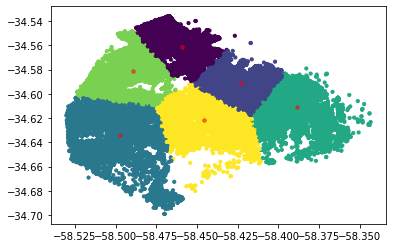

array([[-58.45929494, -34.56104373],
       [-58.42269824, -34.59070106],
       [-58.49753866, -34.63371131],
       [-58.3887584 , -34.61046645],
       [-58.48930486, -34.58103874],
       [-58.44547114, -34.6218895 ]])

In [401]:
from sklearn.cluster import KMeans
# import geopandas as gpd
# countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
# countries[countries["name"] == "Argentina"].plot(color="lightgrey", figsize=(20,10))

x_ejemplo1 = np.column_stack((df.longitud.tolist(), df.latitud.tolist()))
# x_ejemplo1 = np.column_stack((properati.longitud.replace(np.nan,0).tolist(), properati.latitud.replace(np.nan,0).tolist()))

kmeans = KMeans(n_clusters=6)  #Creamos un objeto de la clase KMeans para realizar el agrupamiento
kmeans.fit(x_ejemplo1) #Entrenamos el algoritmo para que aprenda cómo agrupar
y_kmeans = kmeans.predict(x_ejemplo1)
plt.scatter(x_ejemplo1[:, 0], x_ejemplo1[:, 1], c=y_kmeans, s=10, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=50, alpha=0.5,marker='.')
plt.show()
centers

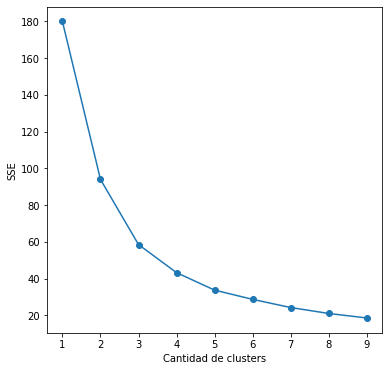

In [402]:
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(x_ejemplo1)
    sse.append(km.inertia_)
    
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Cantidad de clusters')
plt.ylabel('SSE')
plt.show()

#  **3. Clasificación**

#  **4. Regresión**

#  **5. Conclusiones**